In [883]:
import numpy as np
import pandas as pd
import math
import statistics
from scipy import stats, signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast.models import HistoricAverage
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import RandomWalkWithDrift
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import matplotlib.cm as cm
from pandas.plotting import lag_plot

# **Weather Forecasting**

**Brief description of the dataset**\
This dataset provides data on weather from 1st January 2009 to 31st December 2016. This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity, collected every ten minutes.

**Project steps**\
The main aim of this project is to perform weather forecasting for the period January-December 2016.\
Following what we have seen during the lessons, a comprehensive pipeline should be devised, including:
1. Loading, converting and cleaning of the data (note: aggregate the data in order to have weekly frequency).
Divide your dataset into training and testing;
2. Exploring the dataset with descriptive statistics and frequency analysis. Use appropriate graphs to visualise
the data at hand;
3. Describing the time series patterns (visually and numerically);
4. Focusing on temperature (degC, dependent variable), build the most appropriate models to forecast the
data for the specified period. Evaluate the model performance using different metrics. Visualise the results with appropriate graphs.

For the different steps, comment on the main results and any relevant observation/finding you have noticed.

## **Point 1**
Loading, converting and cleaning of the data (note: aggregate the data in order to have weekly frequency).
Divide your dataset into training and testing.

### Load the data

In [884]:
weather_df = pd.read_csv('Weather_ts.csv', sep=',', parse_dates=['Date Time'],  dayfirst=True, index_col='Date Time')
weather_df

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90   93.30   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28   93.40   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31   93.90   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07   94.20   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04   94.10   
...                       ...       ...       ...          ...     ...   
2016-12-31 23:10:00   1000.11     -3.93    269.23        -8.09   72.60   
2016-12-31 23:20:00   1000.07     -4.05    269.10        -8.13   73.10   
2016-12-31 23:30:00    999.93     -3.35    269.81        -8.06   69.71   
2016-12-31 23:40:00    999.82     -3.16    270.01        -8.21   67.91   
2016-12-31 23:50:00    999.81     -4.23    268.94        -8.53   71.80   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00          3.27          3.08          0.19       1.92   
...                           ...           ...           ...        ...   
2016-12-31 23:10:00          4.56          3.31          1.25       2.06   
2016-12-31 23:20:00          4.52          3.30          1.22       2.06   
2016-12-31 23:30:00          4.77          3.32          1.44       2.07   
2016-12-31 23:40:00          4.84          3.28          1.55       2.05   
2016-12-31 23:50:00          4.46          3.20          1.26       1.99   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   
2009-01-01 00:40:00             3.08       1309.19      0.34           0.50   
2009-01-01 00:50:00             3.09       1309.00      0.32           0.63   
...                              ...           ...       ...            ...   
2016-12-31 23:10:00             3.31       1292.41      0.56           1.00   
2016-12-31 23:20:00             3.30       1292.98      0.67           1.52   
2016-12-31 23:30:00             3.32       1289.44      1.14           1.92   
2016-12-31 23:40:00             3.28       1288.39      1.08           2.00   
2016-12-31 23:50:00             3.20       1293.56      1.49           2.16   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6  
2009-01-01 00:40:00     198.0  
2009-01-01 00:50:00     214.3  
...                       ...  
2016-12-31 23:10:00     202.6  
2016-12-31 23:20:00     240.0  
2016-12-31 23:30:00     234.3  
2016-12-31 23:40:00     215.2  
2016-12-31 23:50:00     225.8  

[420550 rows x 14 columns]

The columns are:
1.	Date Time		- Date-time reference 
2.	p (mbar)		- Pressure used to quantify internal pressure (in millibars) 
3.	T (degC)		- Temperature in Celsius
4.	Tpot (K)	    - Temperature in Kelvin
5.	Tdew (degC)		- Temperature in Celsius relative to humidity
6.	rh (%)		    - Relative Humidity 
7.	VPmax (mbar)	- Saturation vapor pressure
8.	VPact (mbar)	- Vapor pressure
9.	VPdef (mbar)	- Vapor pressure deficit 
10.	sh (g/kg)		- Specific humidity
11.	H2OC (mmol/mol)	- Water vapor concentration
12.	rho (g/m**3)	- Airtight 
13.	wv (m/s)		- Wind speed
14.	max. wv (m/s)	- Maximum wind speed
15.	wd (deg)		- Wind direction in degrees

### Study and clean the data

In [885]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420550 entries, 2009-01-01 00:10:00 to 2016-12-31 23:50:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420550 non-null  float64
 1   T (degC)         420550 non-null  float64
 2   Tpot (K)         420550 non-null  float64
 3   Tdew (degC)      420550 non-null  float64
 4   rh (%)           420550 non-null  float64
 5   VPmax (mbar)     420550 non-null  float64
 6   VPact (mbar)     420550 non-null  float64
 7   VPdef (mbar)     420550 non-null  float64
 8   sh (g/kg)        420550 non-null  float64
 9   H2OC (mmol/mol)  420550 non-null  float64
 10  rho (g/m**3)     420550 non-null  float64
 11  wv (m/s)         420550 non-null  float64
 12  max. wv (m/s)    420550 non-null  float64
 13  wd (deg)         420550 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [886]:
print(weather_df.isnull().sum())

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [887]:
print(weather_df.isna().sum())

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


There are no null values in any of the columns, so I don't have to deal with them. All the columns are numeric, so I can use the function .describe() to get some further information about them.

In [888]:
weather_df.describe()

p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean      989.212751       9.450181     283.492779       4.955886   
std         8.358475       8.423346       8.504449       6.730651   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean       76.008260      13.576273       9.533771       4.042419   
std        16.476195       7.739016       4.184158       4.896855   
min        12.950000       0.950000       0.790000       0.000000   
25%        65.210000       7.780000       6.210000       0.870000   
50%        79.300000      11.820000       8.860000       2.190000   
75%        89.400000      17.600000      12.350000       5.300000   
max       100.000000      63.770000      28.320000      46.010000   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  420550.000000    420550.000000  420550.000000  420550.000000   
mean        6.022418         9.640238    1216.062557       1.702225   
std         2.656135         4.235388      39.975064      65.446792   
min         0.500000         0.800000    1059.450000   -9999.000000   
25%         3.920000         6.290000    1187.490000       0.990000   
50%         5.590000         8.960000    1213.790000       1.760000   
75%         7.800000        12.490000    1242.770000       2.860000   
max        18.130000        28.820000    1393.540000      28.490000   

       max. wv (m/s)       wd (deg)  
count  420550.000000  420550.000000  
mean        3.056558     174.743714  
std        69.017014      86.681794  
min     -9999.000000       0.000000  
25%         1.760000     124.900000  
50%         2.960000     198.100000  
75%         4.740000     234.100000  
max        23.500000     360.000000

In [889]:
weather_df.shape

(420550, 14)

In [890]:
for column in weather_df.columns:
    year_stat = weather_df.groupby(weather_df.index.year)[column].describe()
    print(column, year_stat)

p (mbar)              count        mean       std     min     25%      50%     75%  \
Date Time                                                                   
2009       52557.0  987.954039  8.771059  944.58  983.22  989.140  994.26   
2010       52704.0  986.835372  8.231682  952.78  982.01  988.100  992.54   
2011       52560.0  990.806332  7.681367  913.60  985.88  990.690  995.90   
2012       52704.0  989.405777  8.735587  957.03  984.02  989.295  995.01   
2013       52559.0  989.115653  8.105374  961.54  983.98  989.610  994.80   
2014       52647.0  988.216406  6.869515  965.31  983.79  988.180  992.41   
2015       52560.0  991.365497  8.480495  945.64  986.68  991.990  996.99   
2016       52259.0  990.015085  8.836063  956.89  985.09  990.220  995.71   

               max  
Date Time           
2009       1005.71  
2010       1012.47  
2011       1012.03  
2012       1012.84  
2013       1008.94  
2014       1008.41  
2015       1013.94  
2016       1015.35  
T (degC)  

- The **mean** gives a sense of the typical value for each year.
- The **standard deviation** (std) indicates the variability or spread around the mean.
- The **quartiles** (25%, 50% and 75%) provide information about the distribution and skewness of the sales data.
- The **minimum and maximum** (min and max) values give an idea about the range of values.

In [891]:
weather_df.groupby(weather_df.index.year)["T (degC)"].describe()

count       mean       std    min   25%    50%    75%    max
Date Time                                                                
2009       52557.0   8.830284  8.475858 -23.01  2.98   9.12  15.08  32.98
2010       52704.0   7.504652  9.510782 -17.87  0.08   8.09  14.18  34.92
2011       52560.0   9.303914  7.997781 -14.68  3.15   9.25  15.33  33.11
2012       52704.0   9.655535  8.851021 -21.04  4.03   9.30  15.96  35.86
2013       52559.0   9.093978  8.617959 -13.51  2.04   9.29  15.18  35.48
2014       52647.0  10.718917  7.269200 -10.02  5.26  10.73  15.82  33.74
2015       52560.0  10.511207  7.794075  -6.48  4.22  10.09  15.66  37.28
2016       52259.0   9.988671  8.228870 -13.93  3.65   9.14  16.34  34.35

??? when maximum and minimum value for all the columns

### Weekly aggregation of the data

The dataframe has daily frequency, but I aggregate it to have a weekly frequency.

In [892]:
weather_df_weekly = weather_df.resample('W').mean()
weather_df_weekly.head()

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                               
2009-01-04  996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11  999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18  991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25  970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01  990.295337  -2.464573  271.454127    -3.848323  90.406944   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-11         2.372718   1327.335734  1.312153       2.256984  158.967391  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-01-25         5.613720   1230.040417  2.553998       3.973105  188.601022  
2009-02-01         4.663750   1272.179296  1.981885       3.170645   46.615129

I used the .mean() function to aggregate due to the fact that the dataframe is made up of continuous numerical values, so it makes sense.

In [893]:
weather_df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 418 entries, 2009-01-04 to 2017-01-01
Freq: W-SUN
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         418 non-null    float64
 1   T (degC)         418 non-null    float64
 2   Tpot (K)         418 non-null    float64
 3   Tdew (degC)      418 non-null    float64
 4   rh (%)           418 non-null    float64
 5   VPmax (mbar)     418 non-null    float64
 6   VPact (mbar)     418 non-null    float64
 7   VPdef (mbar)     418 non-null    float64
 8   sh (g/kg)        418 non-null    float64
 9   H2OC (mmol/mol)  418 non-null    float64
 10  rho (g/m**3)     418 non-null    float64
 11  wv (m/s)         418 non-null    float64
 12  max. wv (m/s)    418 non-null    float64
 13  wd (deg)         418 non-null    float64
dtypes: float64(14)
memory usage: 49.0 KB


In [894]:
weather_df_weekly.describe()

p (mbar)    T (degC)    Tpot (K)  Tdew (degC)      rh (%)  \
count   418.000000  418.000000  418.000000   418.000000  418.000000   
mean    989.238368    9.428490  283.468976     4.943220   76.047001   
std       6.217979    7.431565    7.454327     6.135823    8.981430   
min     967.816796  -12.640000  259.938155   -15.437232   54.132083   
25%     985.893214    3.707639  277.995749     0.534705   69.596037   
50%     989.290461    9.483542  283.648353     5.367331   76.297877   
75%     992.865556   15.301004  289.378093    10.106562   83.067956   
max    1007.889549   24.770526  298.443155    16.751081   95.171131   

       VPmax (mbar)  VPact (mbar)  VPdef (mbar)   sh (g/kg)  H2OC (mmol/mol)  \
count    418.000000    418.000000    418.000000  418.000000       418.000000   
mean      13.557678      9.526417      4.031179    6.017641         9.632617   
std        6.400325      3.770776      3.033723    2.389490         3.811023   
min        2.419841      1.911012      0.202073    1.180605         1.896250   
25%        8.117391      6.436109      1.544459    4.040732         6.480258   
50%       12.371086      9.073214      3.243462    5.703398         9.136746   
75%       17.964365     12.528566      5.945732    7.911840        12.657299   
max       33.085079     19.144921     16.535179   12.155169        19.398016   

       rho (g/m**3)    wv (m/s)  max. wv (m/s)    wd (deg)  
count    418.000000  418.000000     418.000000  418.000000  
mean    1216.192035    1.701207       3.054848  174.800532  
std       34.602324    8.760265       9.746778   35.462175  
min     1151.149742 -176.614435    -194.960387   46.615129  
25%     1188.048755    1.734730       2.908113  153.013038  
50%     1212.522202    2.021007       3.398120  182.851230  
75%     1239.563063    2.411503       4.009271  201.698418  
max     1347.082302    4.619732       7.043562  240.663601

### Train and test split

The main aim of this project is to perform weather forecasting for the period January-December 2016, so I split the dataframe accordingly

In [895]:
split = '2016-01-01'
train = weather_df_weekly[weather_df_weekly.index < split]
test = weather_df_weekly[weather_df_weekly.index >= split]

In [896]:
test.tail()

p (mbar)  T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                               
2016-12-04   999.956121 -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891  1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288  2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817  1.969593  275.060228    -0.343909  85.042927   
2017-01-01  1007.889549  2.689560  275.233866    -0.238472  81.632986   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   
2017-01-01      7.702361      6.203750      1.498484   3.838715   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  
2017-01-01         6.156250   1270.206458  1.972280       3.632130  222.820949

The test dataframe has one row with value for the year 2017, I keep it anyway cause it gives me information about the last week of 2016.

## Point 2
Exploring the dataset with descriptive statistics and frequency analysis. Use appropriate graphs to visualise
the data at hand.

### Line plots

In [897]:
columns = list(weather_df)

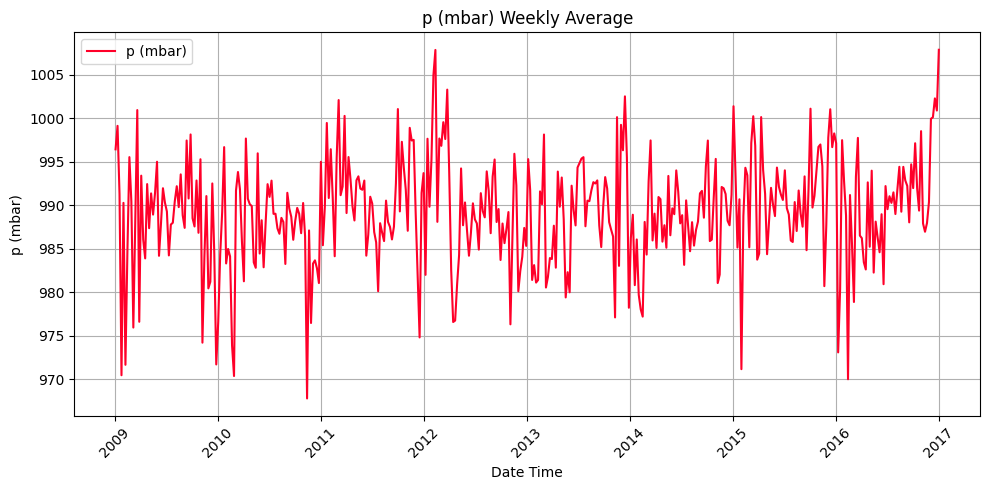

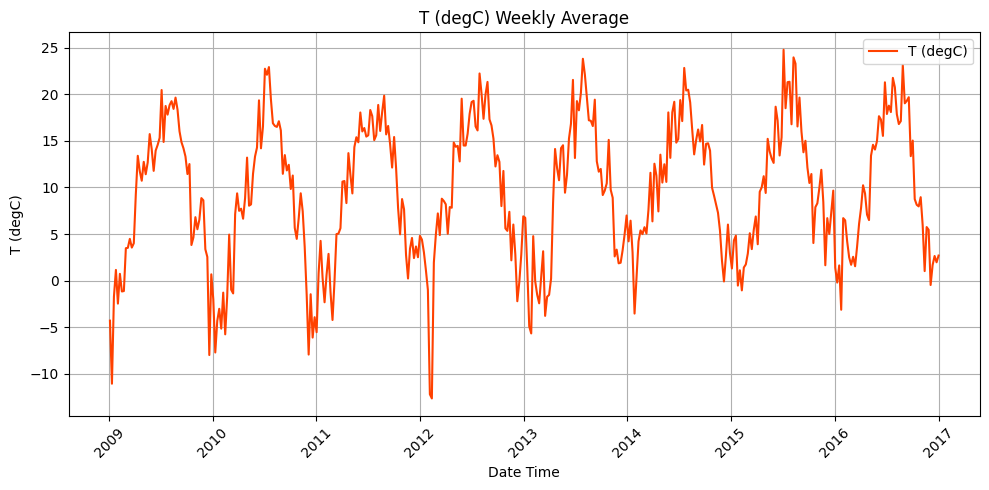

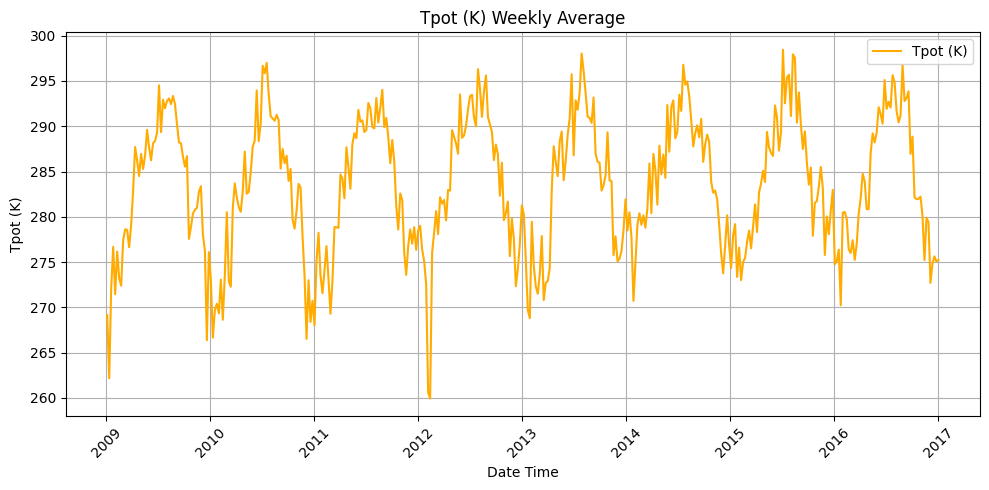

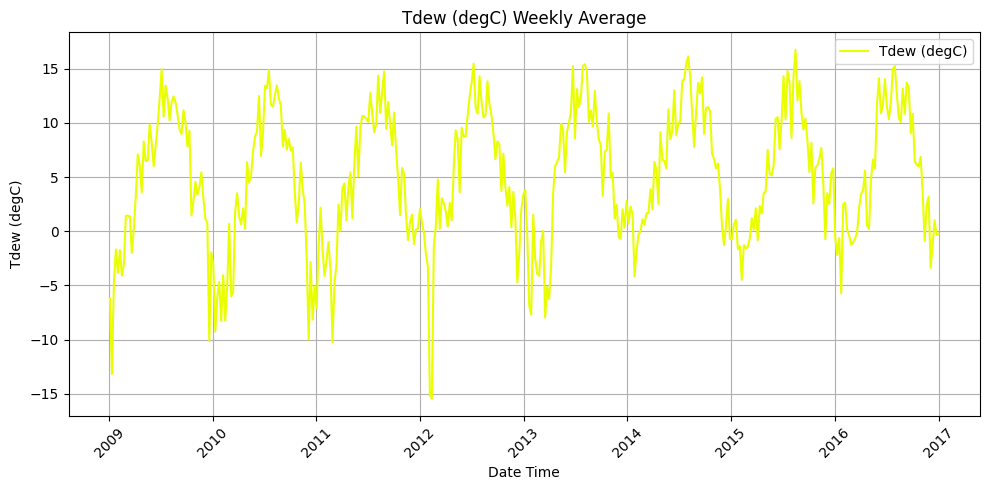

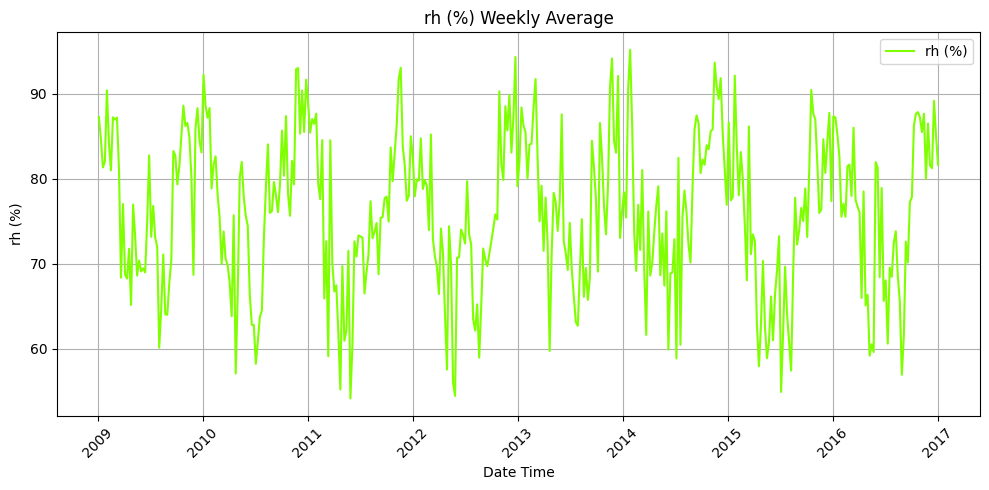

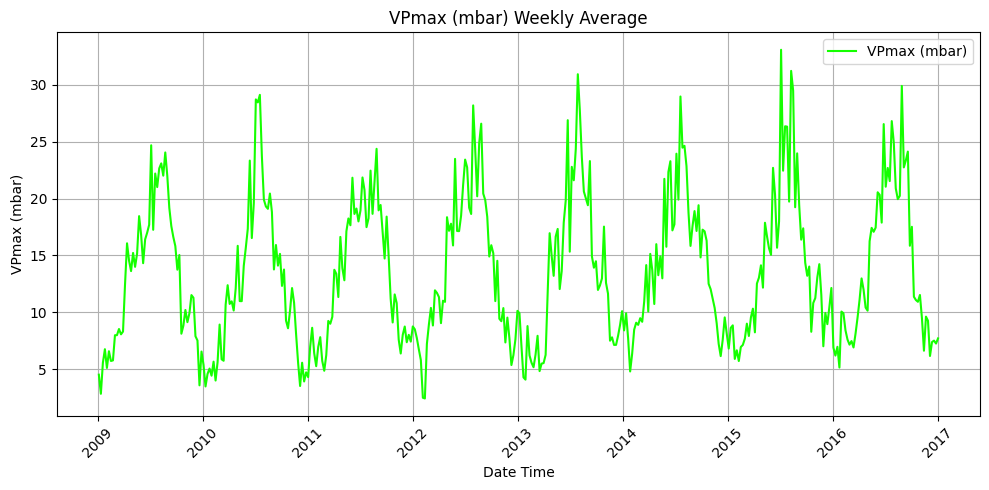

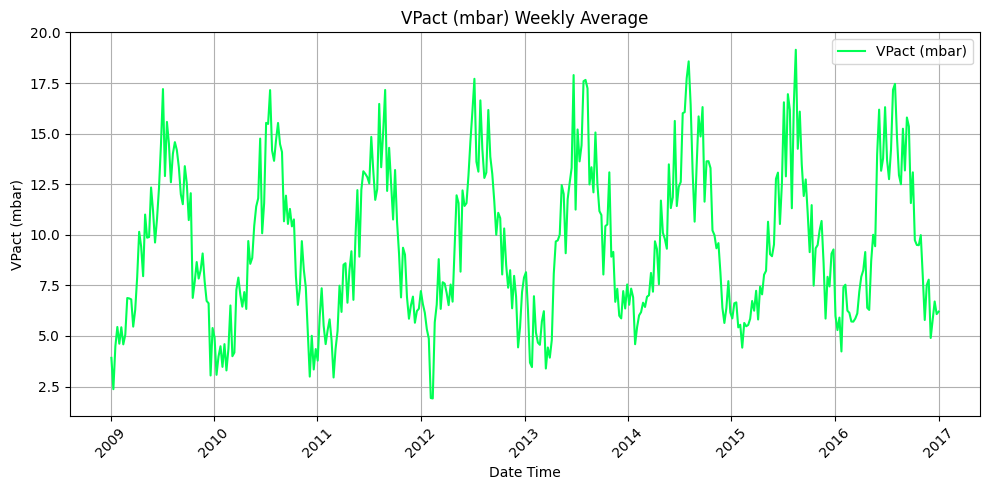

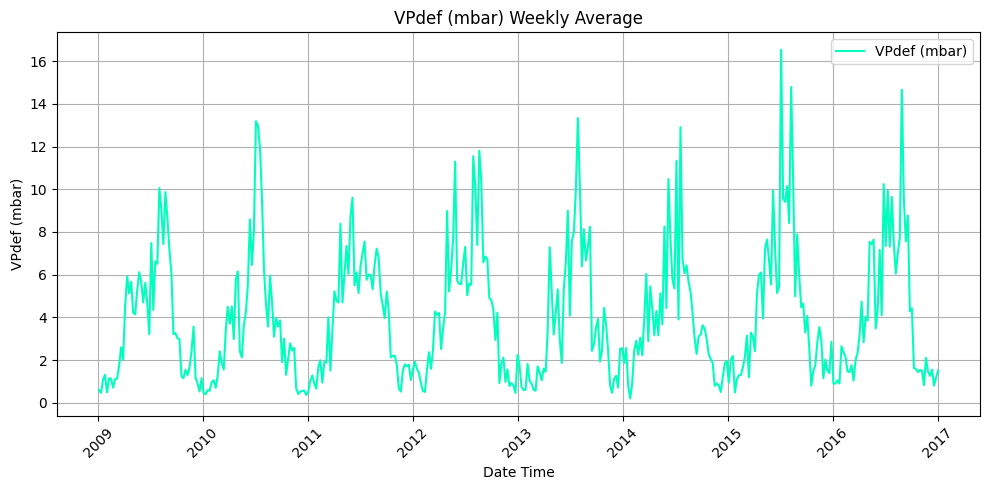

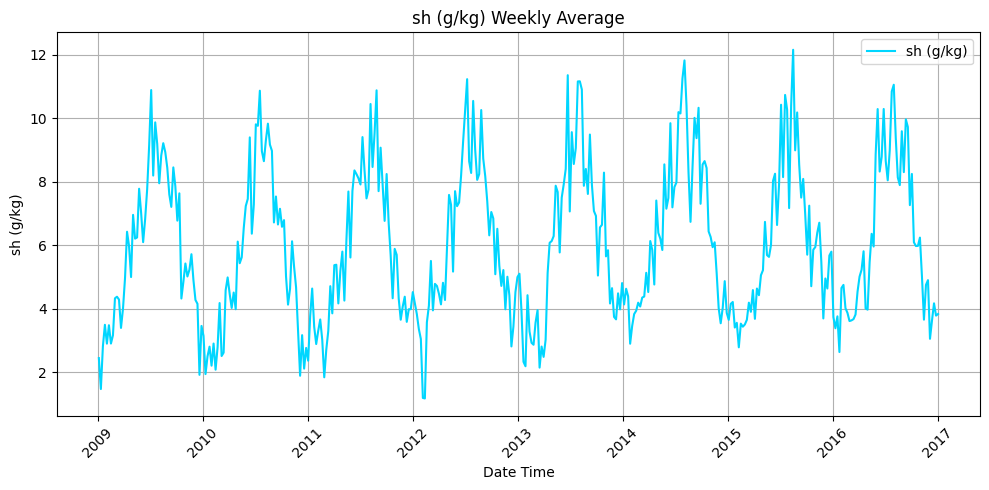

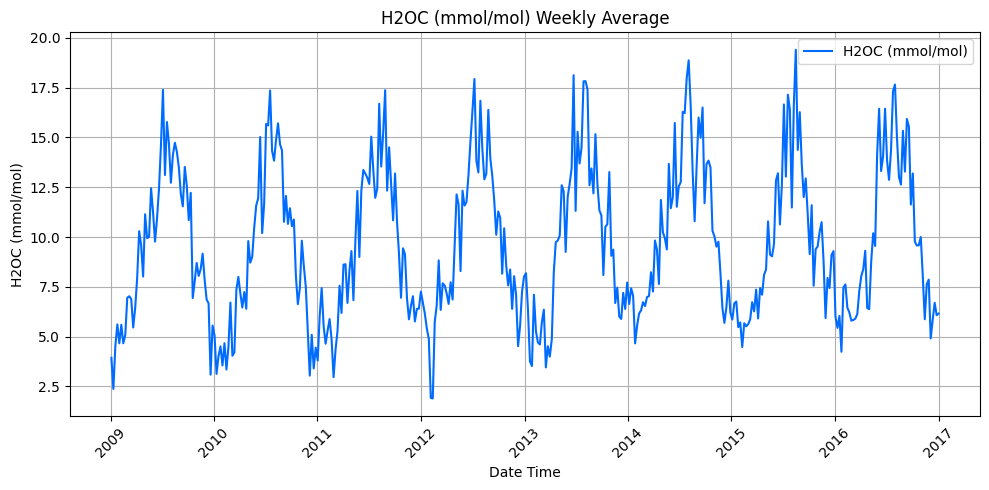

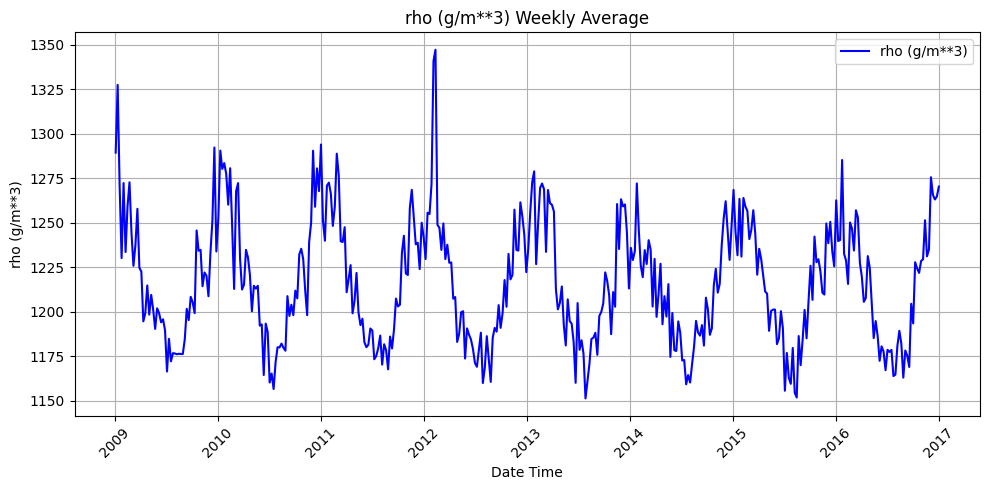

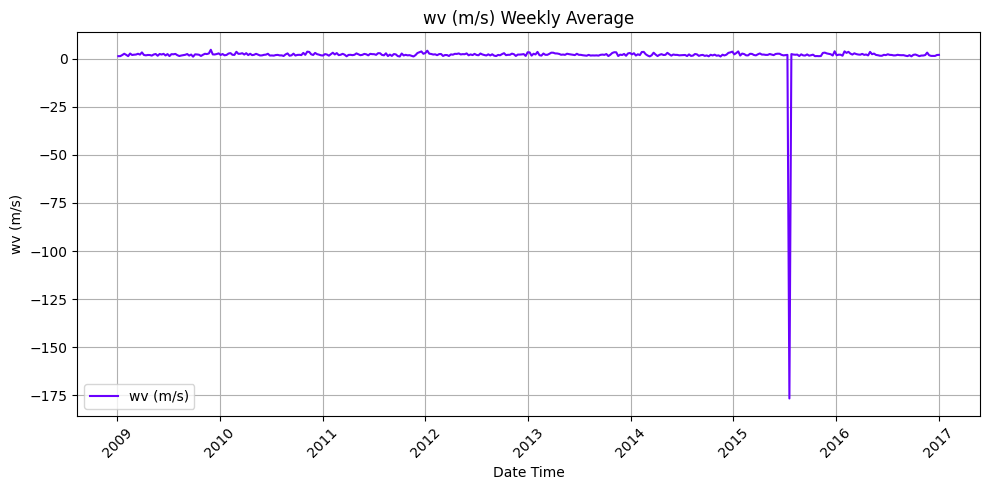

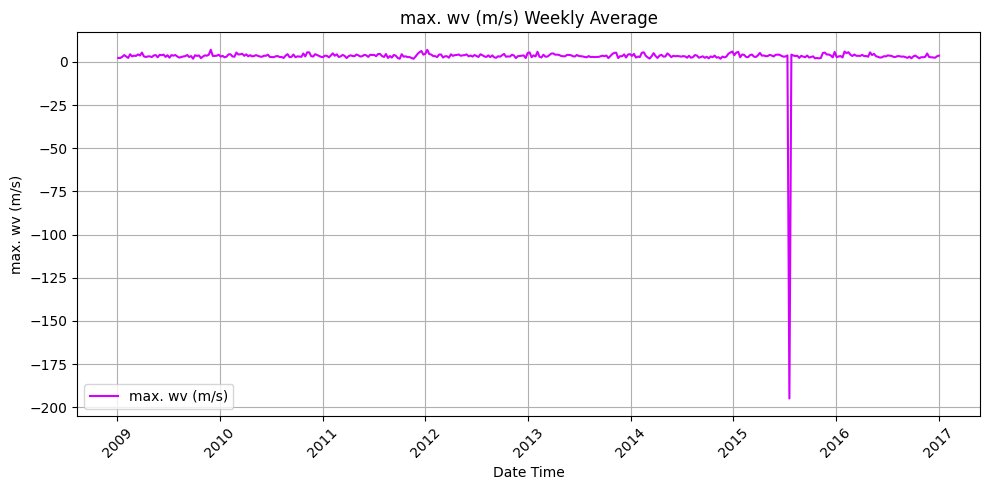

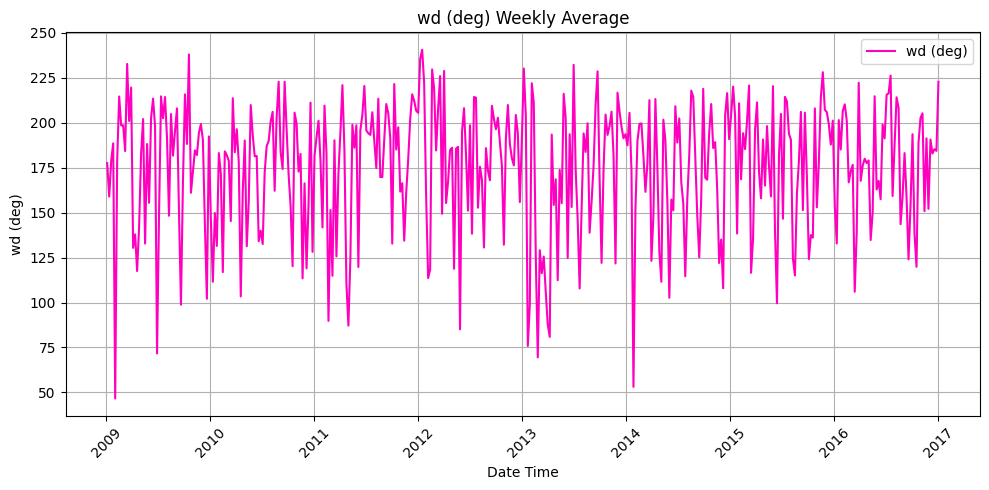

In [898]:
cmap = cm.get_cmap('gist_rainbow', len(columns))

for colore, column in enumerate(columns):
    plt.figure(figsize=(10, 5))
    plt.plot(weather_df_weekly.index, weather_df_weekly[column], label=column, color=cmap(colore))
    plt.title(f'{column} Weekly Average')
    plt.xlabel('Date Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

By looking at the graphs, we can spot seasonal patterns for most of the columns, which is expected.

It's also clear that the column 'wv (m/s)' and 'max. wv (m/s)' both have an outlier in the year 2015.

In [899]:
print(weather_df_weekly.loc['2015', 'wv (m/s)'].min())
print(weather_df_weekly.loc['2015', 'max. wv (m/s)'].min())

-176.61443452380954
-194.96038690476192


The values are so significantly different from the rest of the data that we can assume they are a mistake.

### Correlation

In [900]:
correlation_matrix = weather_df_weekly.corr()
correlation_matrix

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
p (mbar)         1.000000  0.027832 -0.039525     0.011353 -0.053637   
T (degC)         0.027832  1.000000  0.997730     0.969344 -0.626309   
Tpot (K)        -0.039525  0.997730  1.000000     0.968185 -0.622519   
Tdew (degC)      0.011353  0.969344  0.968185     1.000000 -0.417848   
rh (%)          -0.053637 -0.626309 -0.622519    -0.417848  1.000000   
VPmax (mbar)     0.044319  0.970678  0.967341     0.925806 -0.642372   
VPact (mbar)     0.022568  0.950386  0.948549     0.976945 -0.416997   
VPdef (mbar)     0.065444  0.866563  0.861806     0.738885 -0.836910   
sh (g/kg)        0.010454  0.949749  0.948736     0.976503 -0.416256   
H2OC (mmol/mol)  0.010443  0.950039  0.949026     0.976813 -0.416378   
rho (g/m**3)     0.201229 -0.973137 -0.986291    -0.951531  0.587667   
wv (m/s)        -0.022969 -0.090724 -0.089152    -0.093907  0.029708   
max. wv (m/s)   -0.028693 -0.089489 -0.087527    -0.095045  0.019868   
wd (deg)        -0.074275  0.121678  0.126894     0.126692 -0.097112   

                 VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
p (mbar)             0.044319      0.022568      0.065444   0.010454   
T (degC)             0.970678      0.950386      0.866563   0.949749   
Tpot (K)             0.967341      0.948549      0.861806   0.948736   
Tdew (degC)          0.925806      0.976945      0.738885   0.976503   
rh (%)              -0.642372     -0.416997     -0.836910  -0.416256   
VPmax (mbar)         1.000000      0.952574      0.925707   0.952087   
VPact (mbar)         0.952574      1.000000      0.766704   0.999912   
VPdef (mbar)         0.925707      0.766704      1.000000   0.765784   
sh (g/kg)            0.952087      0.999912      0.765784   1.000000   
H2OC (mmol/mol)      0.952062      0.999914      0.765731   0.999999   
rho (g/m**3)        -0.934818     -0.926139     -0.821049  -0.928228   
wv (m/s)            -0.112540     -0.113308     -0.096596  -0.113210   
max. wv (m/s)       -0.112645     -0.115588     -0.093984  -0.115414   
wd (deg)             0.045504      0.068541      0.010812   0.069610   

                 H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
p (mbar)                0.010443      0.201229 -0.022969      -0.028693   
T (degC)                0.950039     -0.973137 -0.090724      -0.089489   
Tpot (K)                0.949026     -0.986291 -0.089152      -0.087527   
Tdew (degC)             0.976813     -0.951531 -0.093907      -0.095045   
rh (%)                 -0.416378      0.587667  0.029708       0.019868   
VPmax (mbar)            0.952062     -0.934818 -0.112540      -0.112645   
VPact (mbar)            0.999914     -0.926139 -0.113308      -0.115588   
VPdef (mbar)            0.765731     -0.821049 -0.096596      -0.093984   
sh (g/kg)               0.999999     -0.928228 -0.113210      -0.115414   
H2OC (mmol/mol)         1.000000     -0.928541 -0.113066      -0.115265   
rho (g/m**3)           -0.928541      1.000000  0.082186       0.079688   
wv (m/s)               -0.113066      0.082186  1.000000       0.999558   
max. wv (m/s)          -0.115265      0.079688  0.999558       1.000000   
wd (deg)                0.070004     -0.142262 -0.039374      -0.025644   

                 wd (deg)  
p (mbar)        -0.074275  
T (degC)         0.121678  
Tpot (K)         0.126894  
Tdew (degC)      0.126692  
rh (%)          -0.097112  
VPmax (mbar)     0.045504  
VPact (mbar)     0.068541  
VPdef (mbar)     0.010812  
sh (g/kg)        0.069610  
H2OC (mmol/mol)  0.070004  
rho (g/m**3)    -0.142262  
wv (m/s)        -0.039374  
max. wv (m/s)   -0.025644  
wd (deg)         1.000000

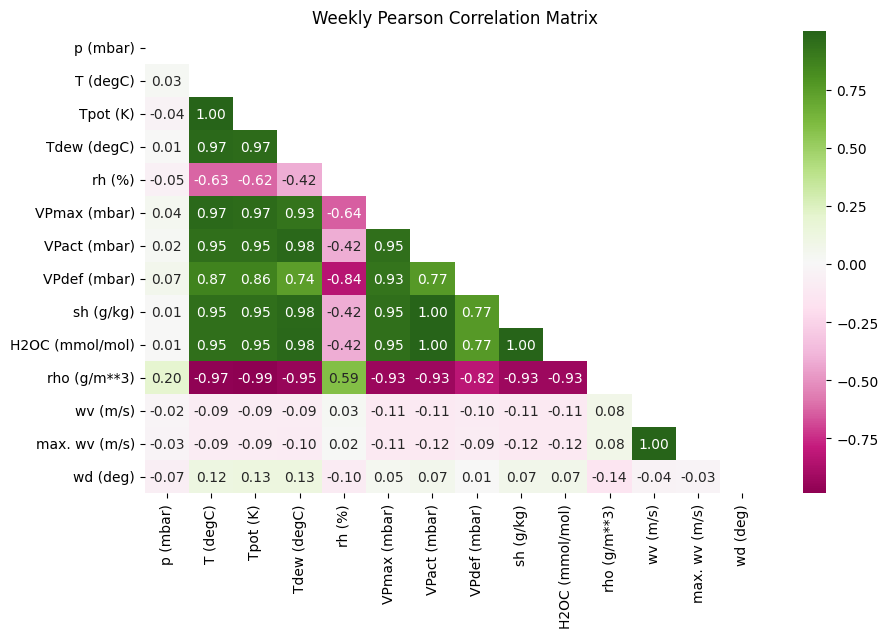

In [901]:
plt.figure(figsize=(10, 6))
pearson_corr = weather_df_weekly.corr(method='pearson') 
matrix = np.triu(pearson_corr)
sns.heatmap(pearson_corr, annot=True, cmap='PiYG', fmt=".2f", cbar=True,mask=matrix)
plt.title('Weekly Pearson Correlation Matrix')
plt.show()

As expected, the temperature columns are highly correlated, same for the columns for humidity and water vapor concentration. It makes sense that the columns for meteorological are correlated with each others, excluding the ones about the wind (though, there is of course an high correlation between wind speed and maximum wind speed.)

### Heatmaps

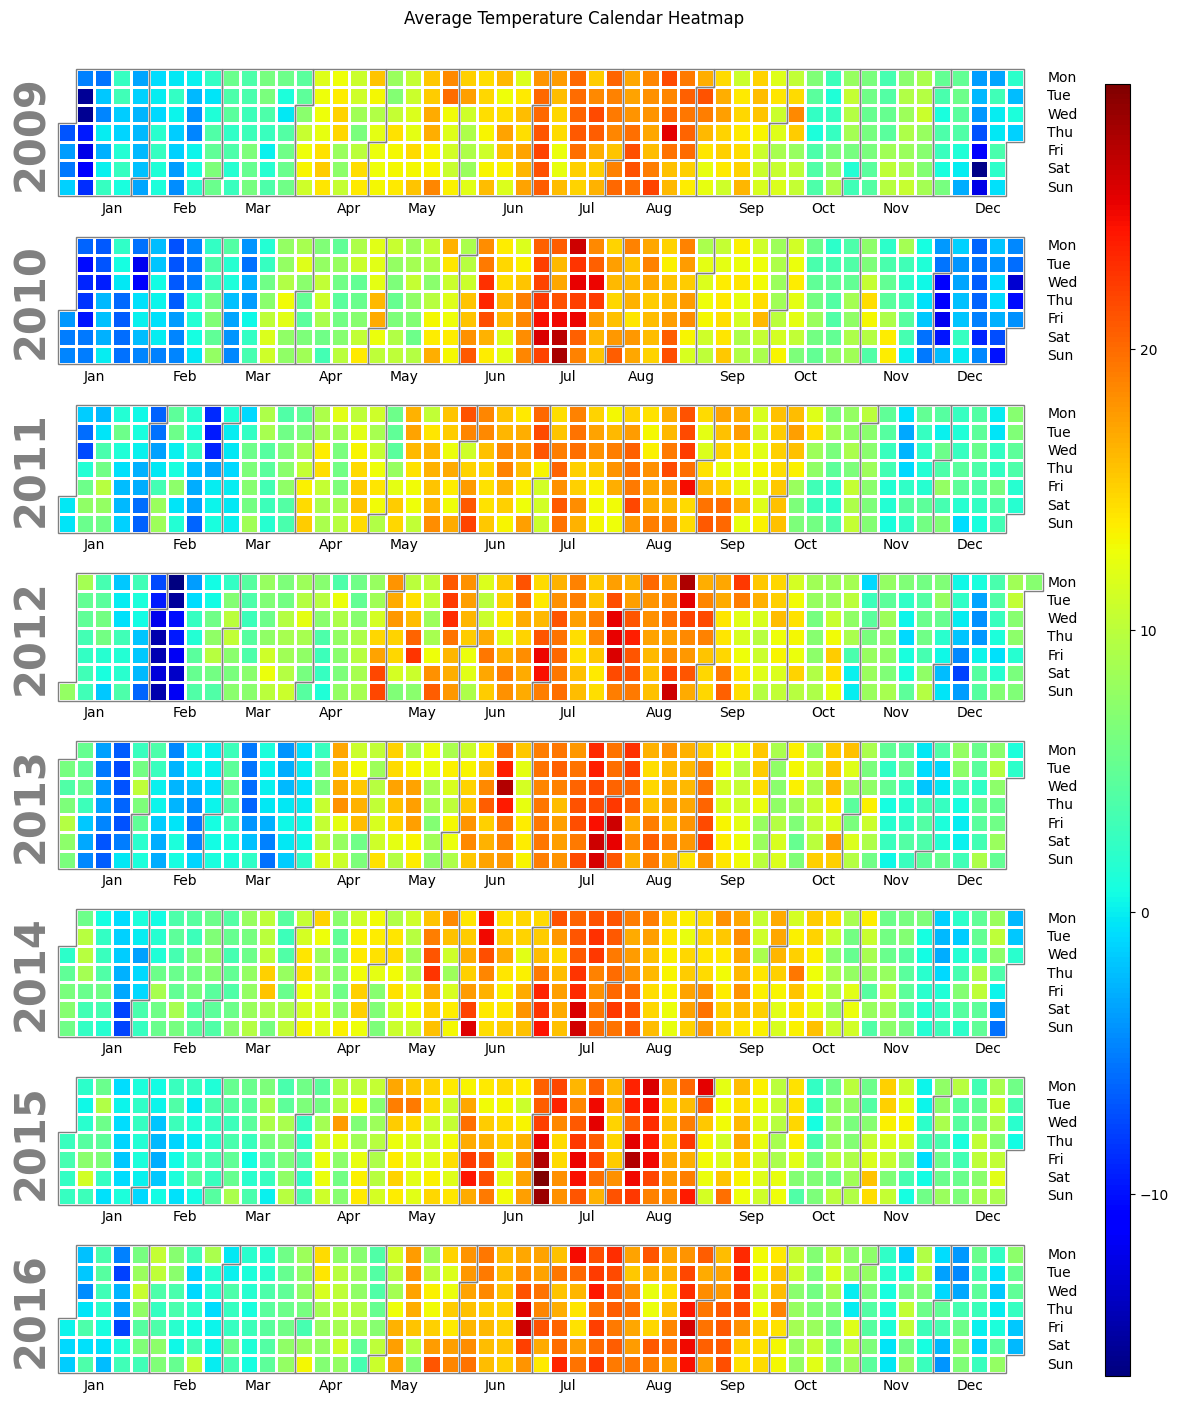

In [902]:
weather_df_daily = weather_df.resample('D').mean()

calplot.calplot(
    weather_df_daily['T (degC)'], 
    cmap='jet', 
    colorbar=True, 
    suptitle="Average Temperature Calendar Heatmap",
    yearlabel_kws={'fontname':'sans-serif'})
plt.show()

I wanted to use a july.heatmap(), but I had some deprecation issues with Matplotlib.

### Box plots

In [903]:
# Add one colum to indicate the year (DatetimeIndex -> PeriodIndex)
weather_df_weekly_period = weather_df_weekly.copy()
weather_df_weekly_period['Period_Y'] = weather_df_weekly_period.index.to_period('Y')
weather_df_weekly_period.head(5)

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                               
2009-01-04  996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11  999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18  991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25  970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01  990.295337  -2.464573  271.454127    -3.848323  90.406944   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                            
2009-01-04         3.934887   1289.293165  1.293252       2.310504   
2009-01-11         2.372718   1327.335734  1.312153       2.256984   
2009-01-18         4.526012   1270.352133  1.879524       2.970417   
2009-01-25         5.613720   1230.040417  2.553998       3.973105   
2009-02-01         4.663750   1272.179296  1.981885       3.170645   

              wd (deg) Period_Y  
Date Time                        
2009-01-04  177.589652     2009  
2009-01-11  158.967391     2009  
2009-01-18  178.882599     2009  
2009-01-25  188.601022     2009  
2009-02-01   46.615129     2009

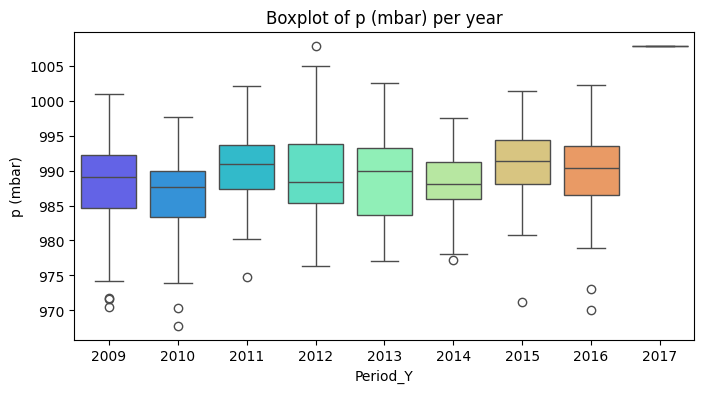

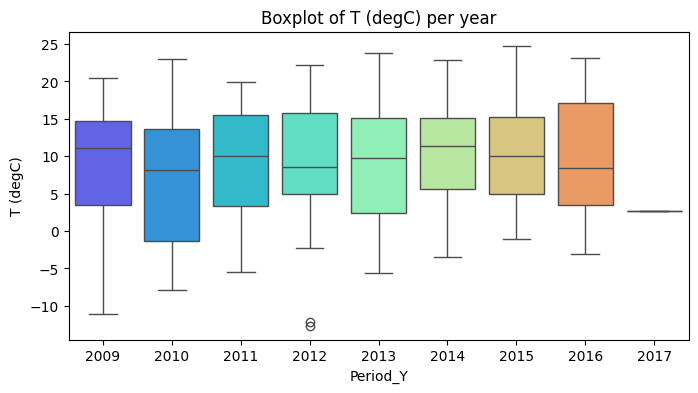

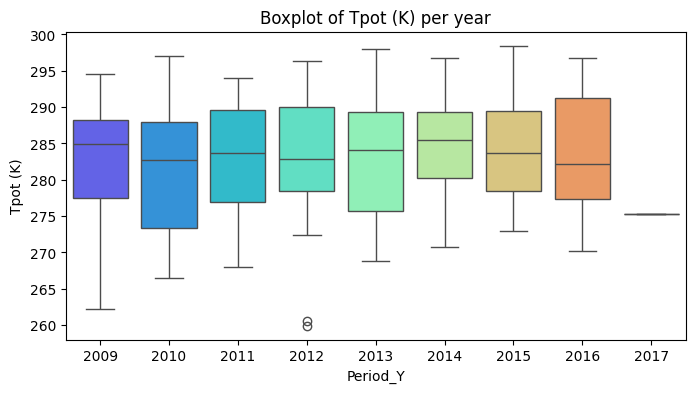

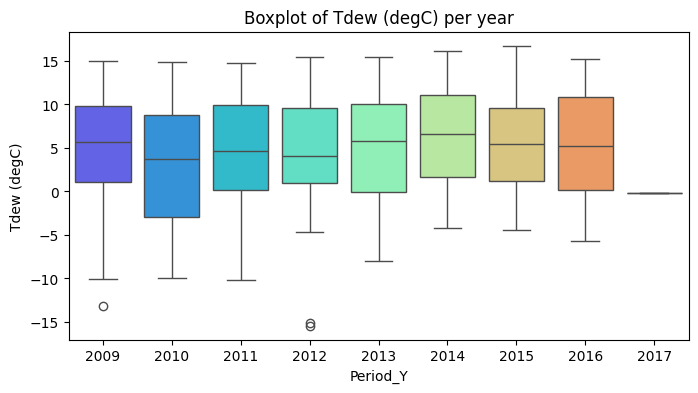

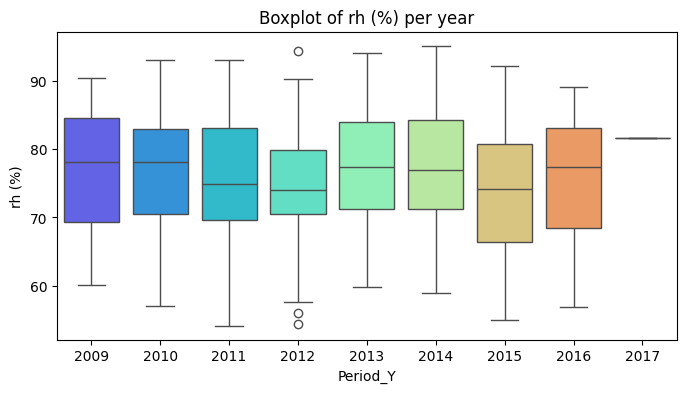

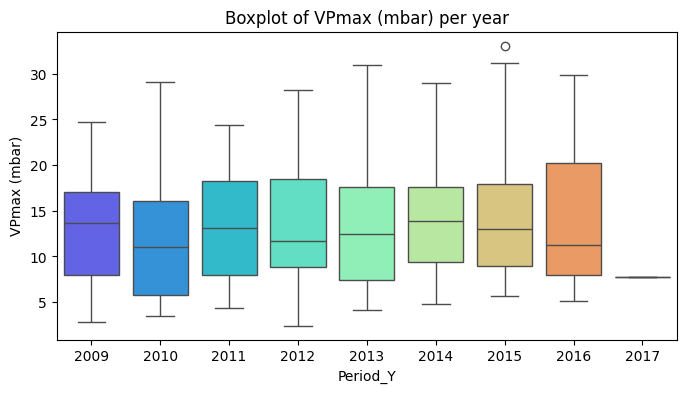

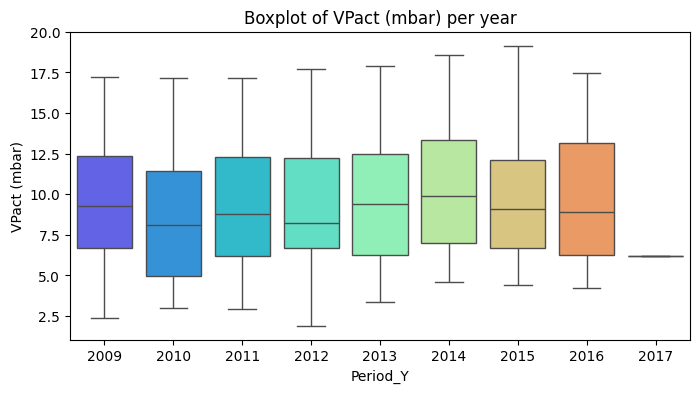

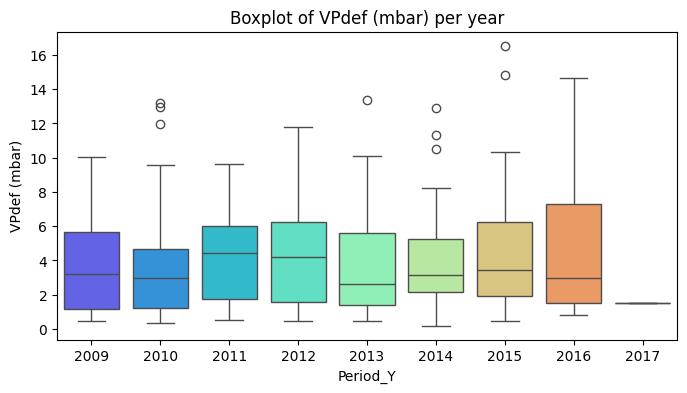

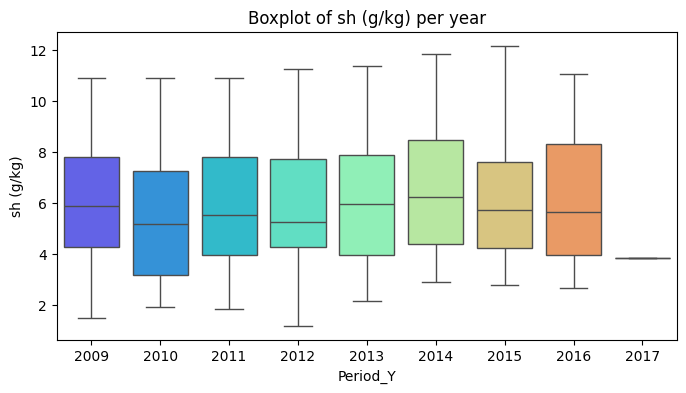

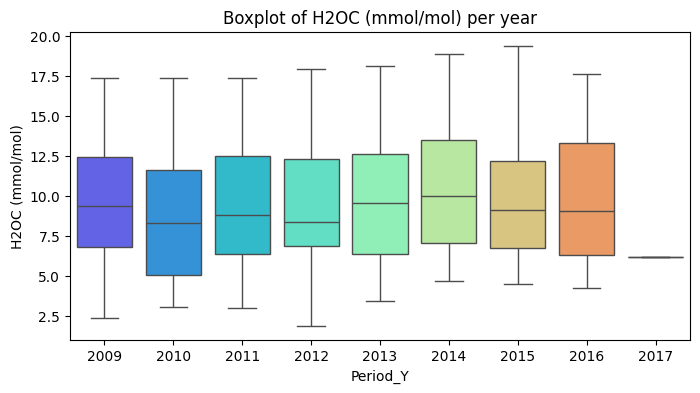

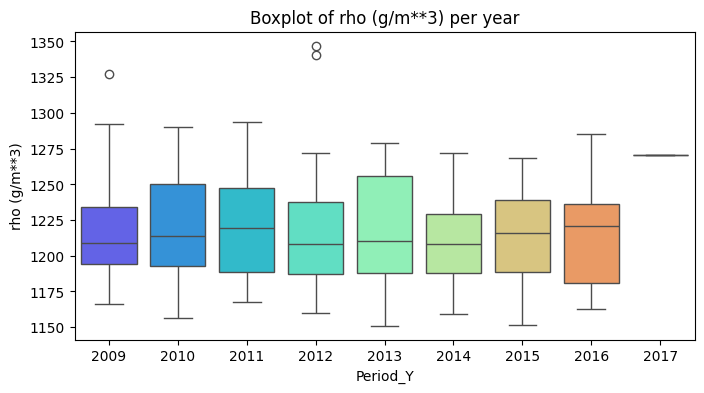

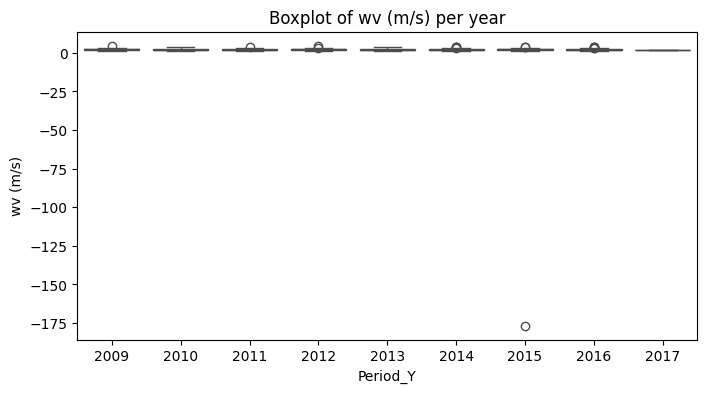

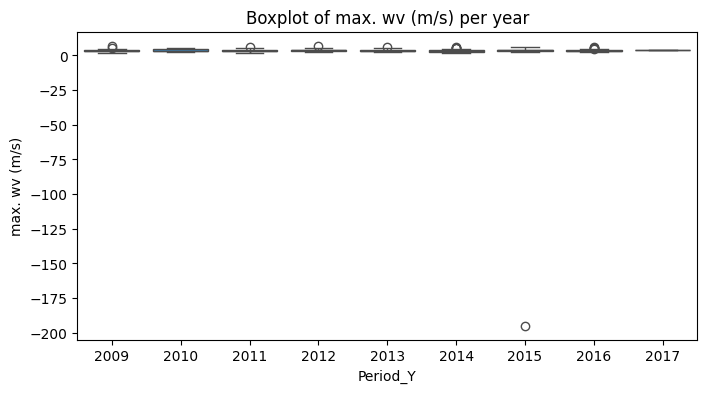

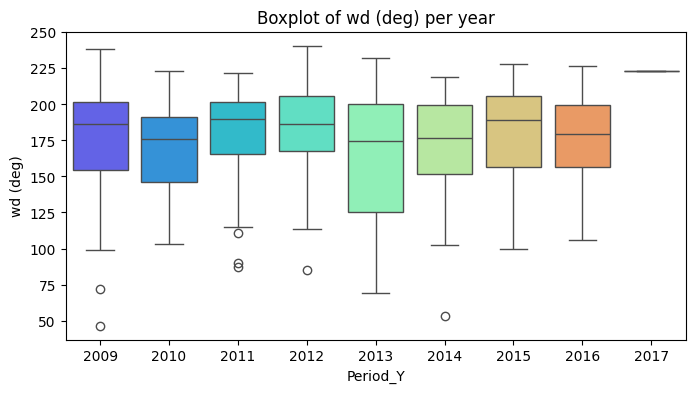

In [904]:
for column in weather_df_weekly_period.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8,4))
    plt.title('Boxplot of ' + column + ' per year')
    sns.boxplot(x = weather_df_weekly_period['Period_Y'], y = weather_df_weekly_period[column], palette='rainbow')
    plt.show()

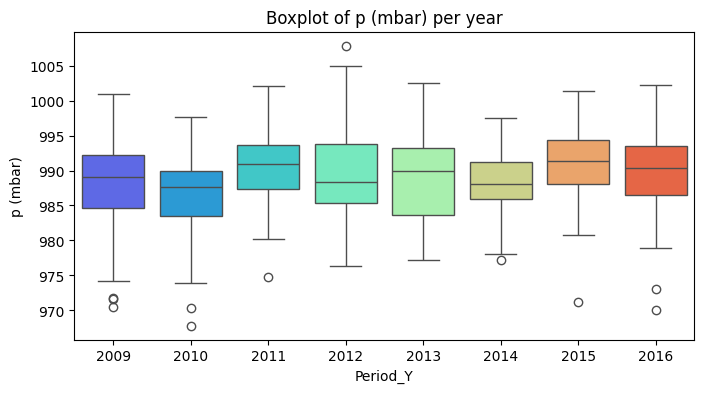

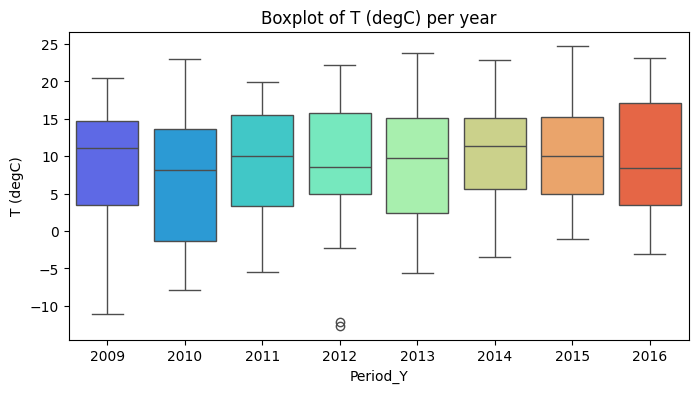

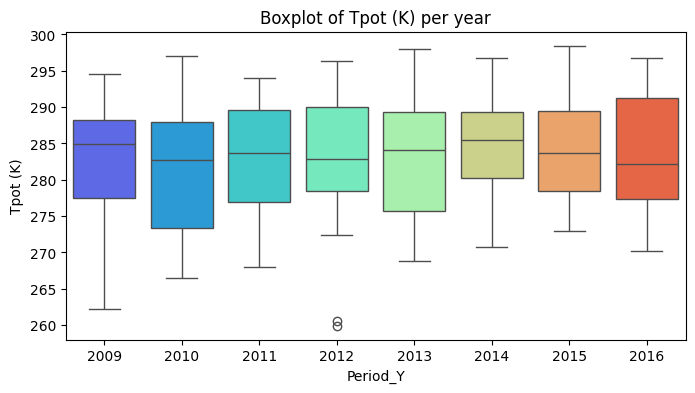

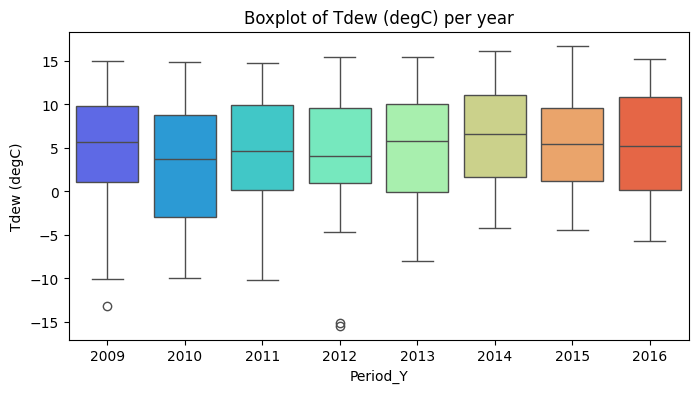

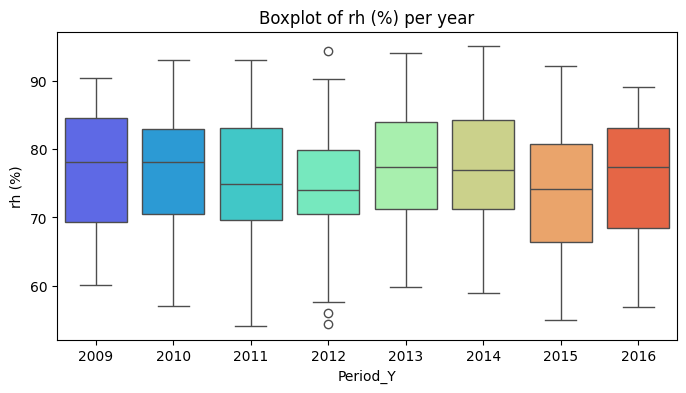

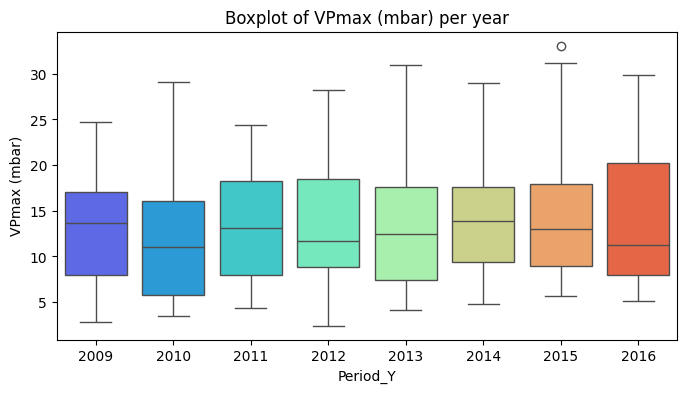

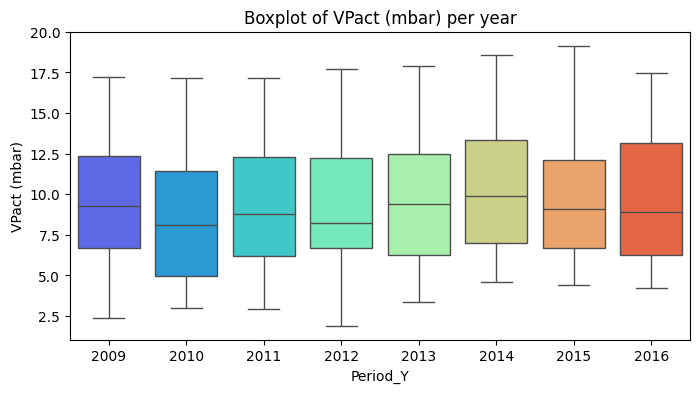

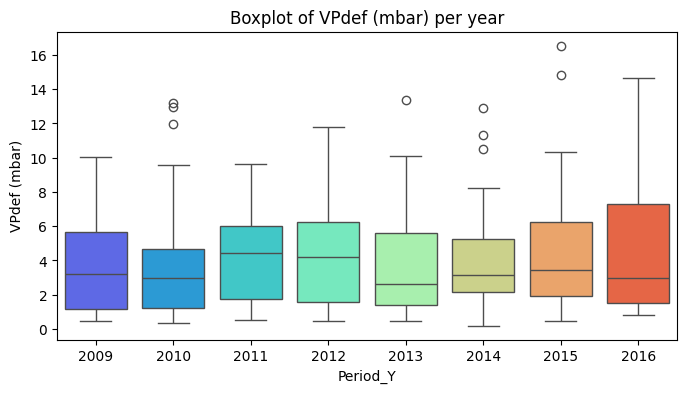

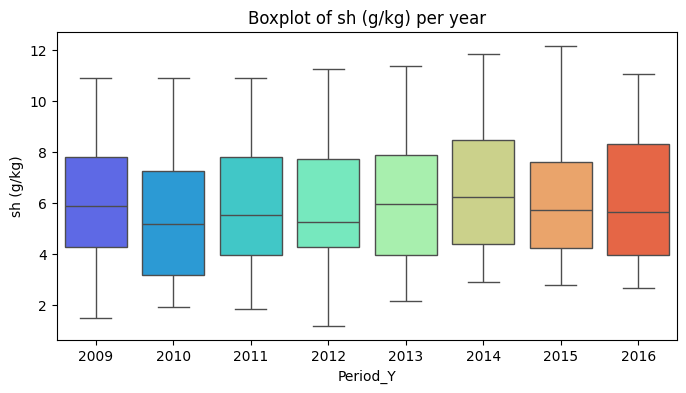

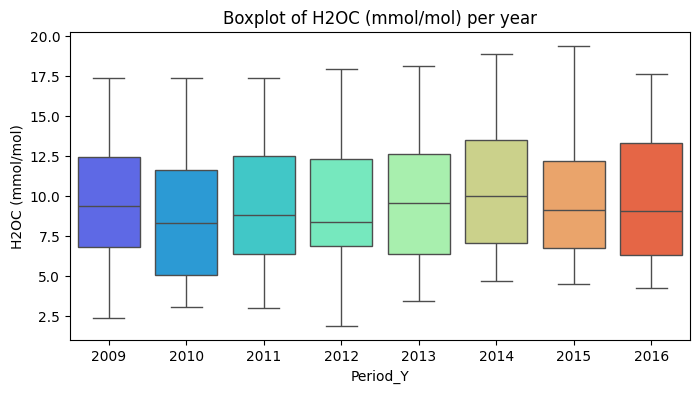

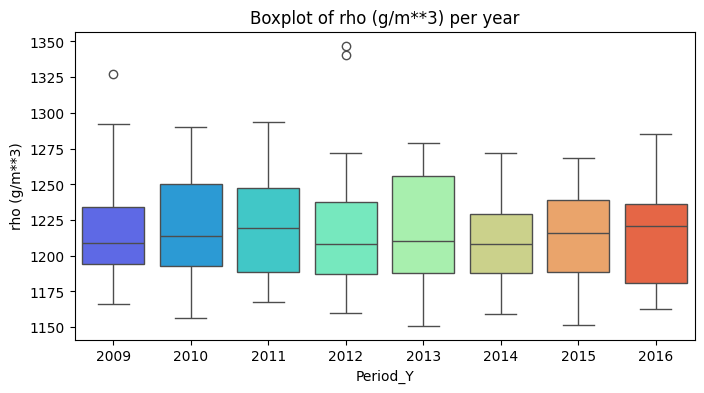

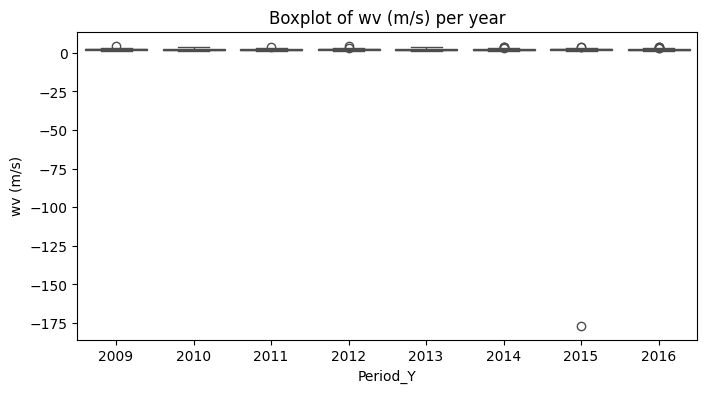

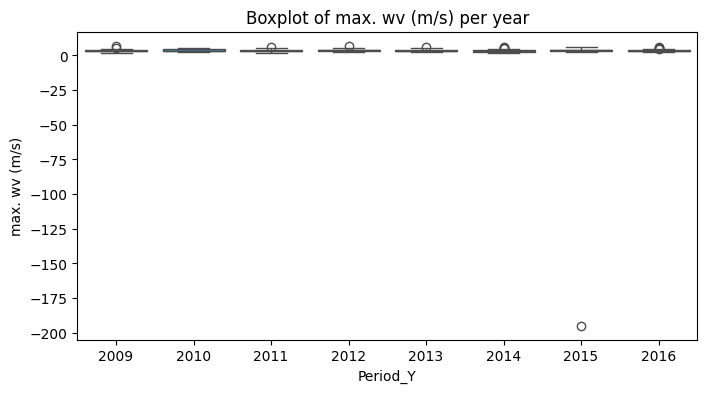

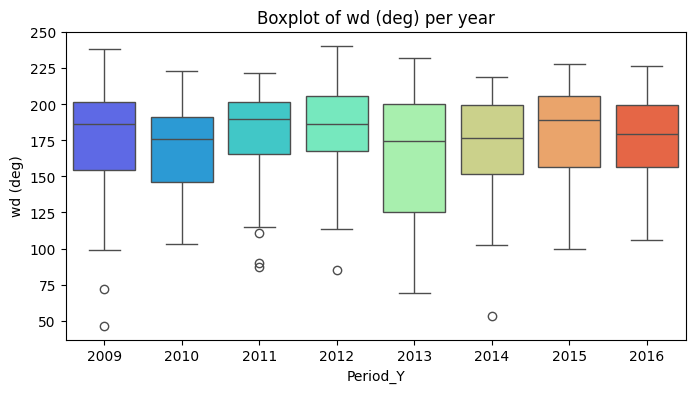

In [905]:
weather_df_weekly_period = weather_df_weekly_period[weather_df_weekly_period['Period_Y'] != '2017']

for column in weather_df_weekly_period.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8,4))
    plt.title('Boxplot of ' + column + ' per year')
    sns.boxplot(x = weather_df_weekly_period['Period_Y'], y = weather_df_weekly_period[column], palette='rainbow')
    plt.show()

The Box plots shows that several columns have some outliers, but the most significative ones are in 'wv (m/s)' and 'max. wv (m/s)' (as seen in the Line plots).

Box plot by month for the year 2013.

In [906]:
# Boxplot representing the monthly data for a specific year (2016)
weather_df_2016 = weather_df_weekly_period.loc[weather_df_weekly_period['Period_Y'] == '2016']
weather_df_2016['Period_MY'] = weather_df_2016.index.to_period('M')

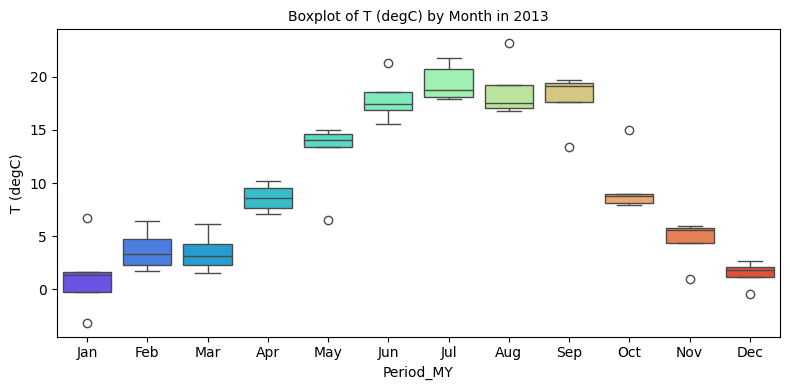

In [907]:
# For ease of visualization, we can then use dt.strftime() to convert to Index using specified date_format. It returns an Index of formatted strings.
plt.figure(figsize=(8,4))
sns.boxplot(x=weather_df_2016['Period_MY'].dt.strftime('%b'),y = weather_df_2016['T (degC)'], palette='rainbow')
plt.title('Boxplot of T (degC) by Month in 2013', fontsize=10)
plt.tight_layout()
plt.show()

### Violin plots

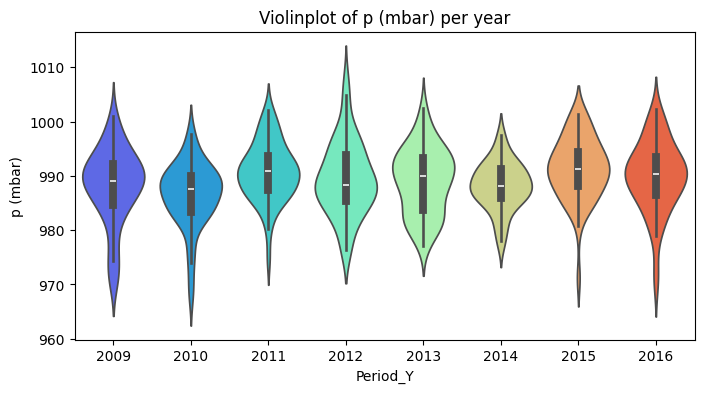

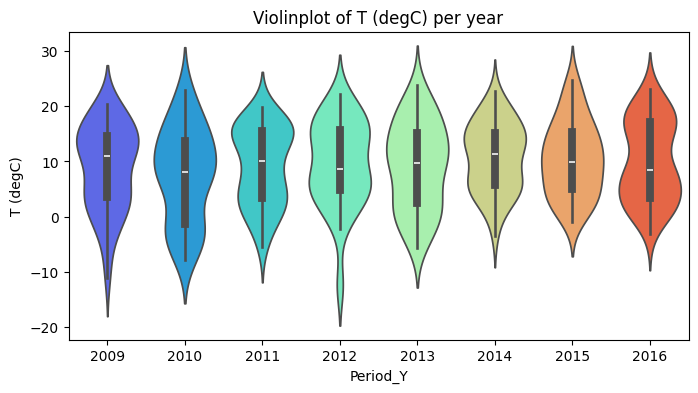

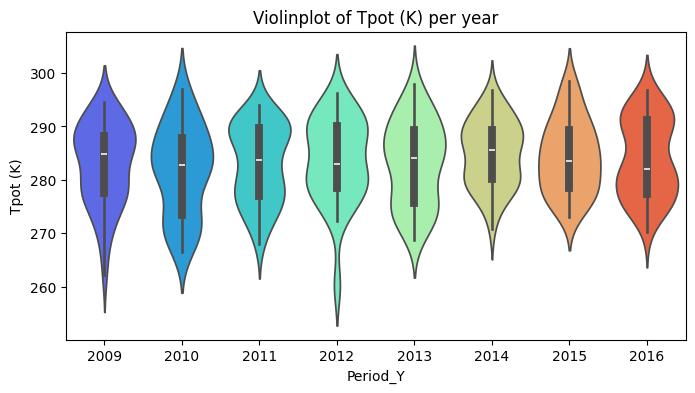

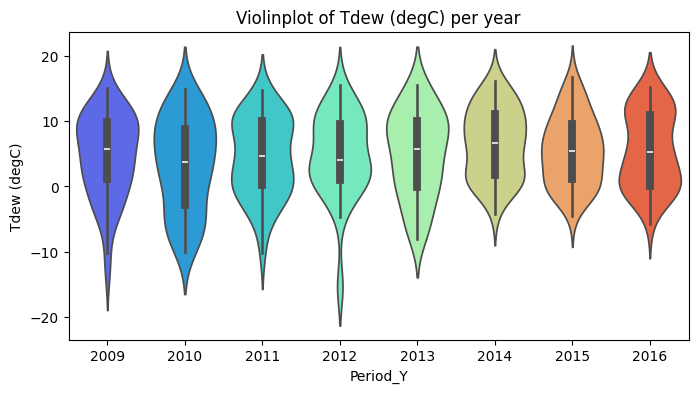

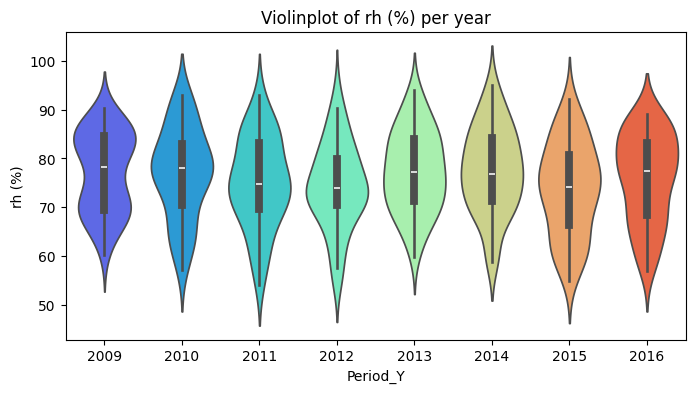

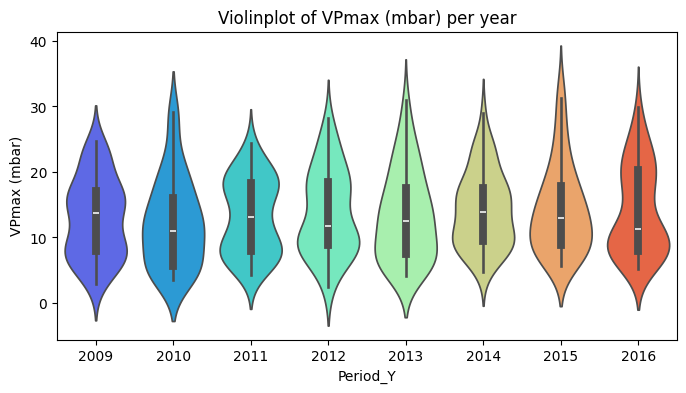

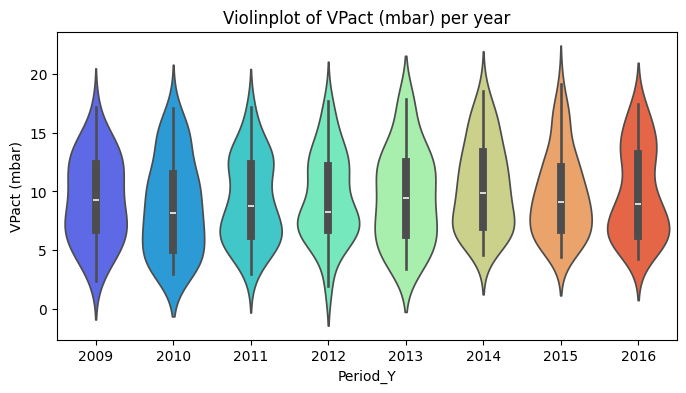

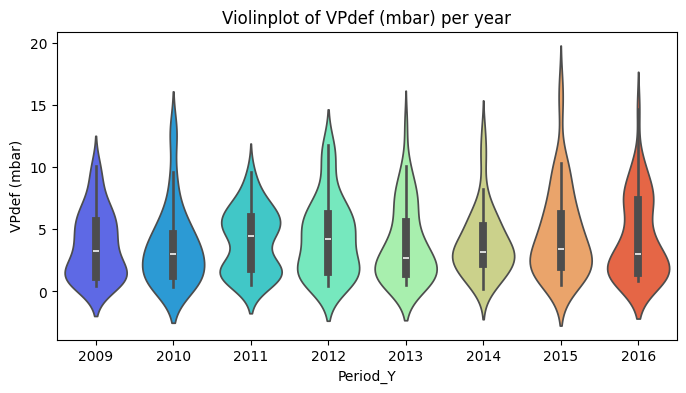

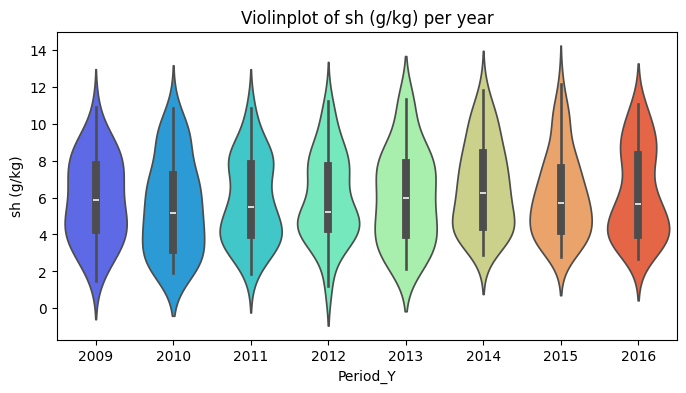

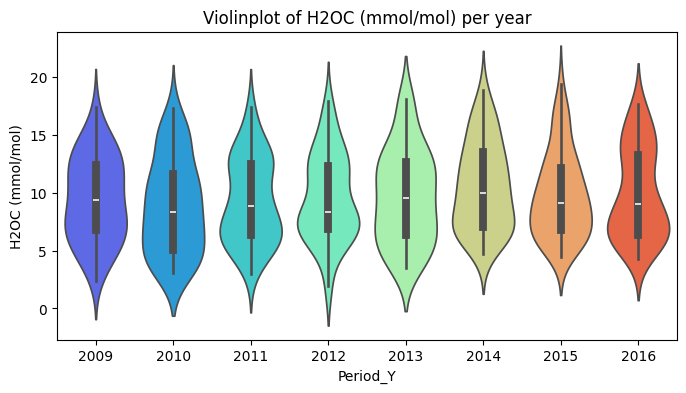

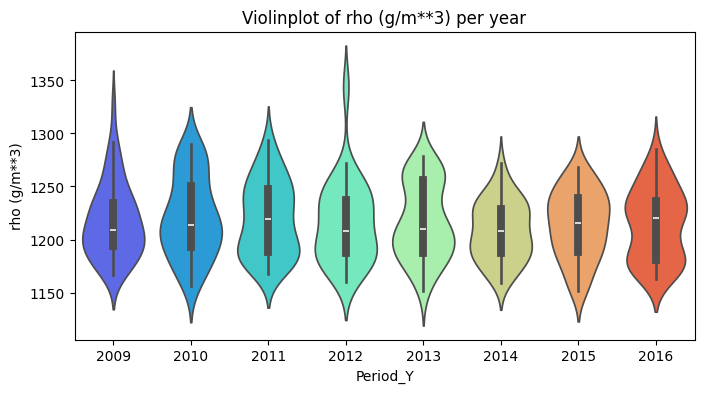

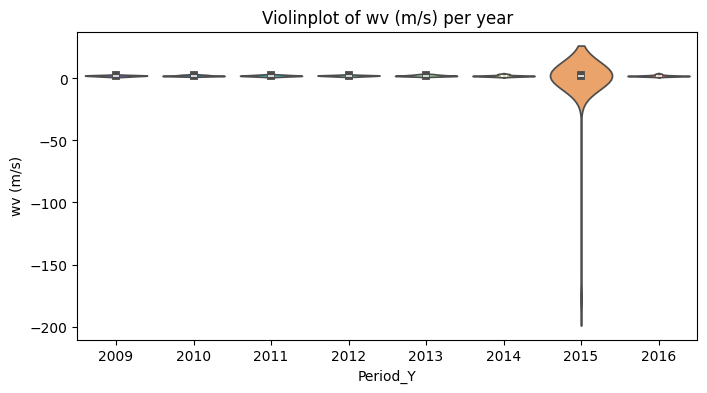

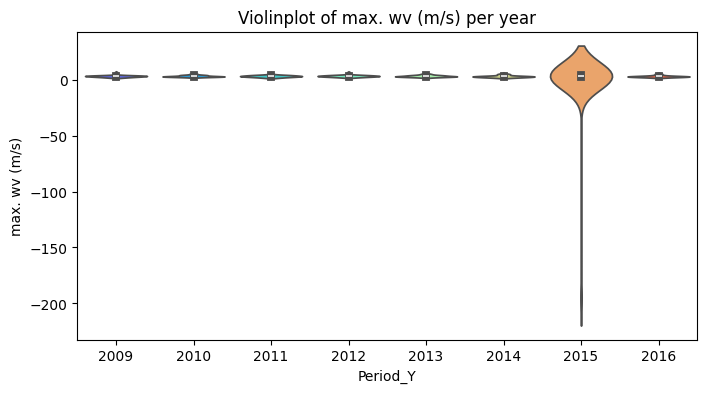

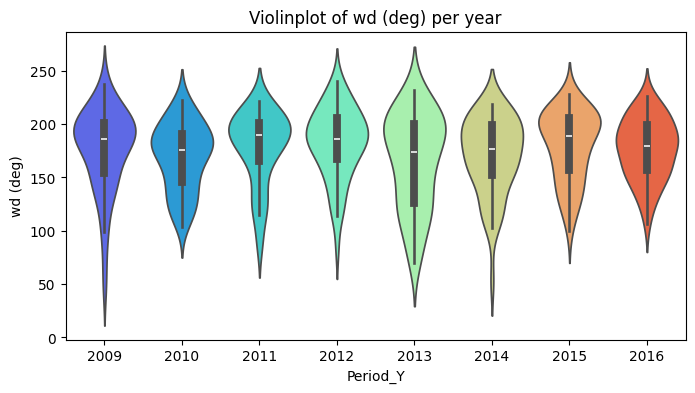

In [908]:
for column in weather_df_weekly_period.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8,4))
    plt.title('Violinplot of ' + column + ' per year')
    sns.violinplot(x = weather_df_weekly_period['Period_Y'], y = weather_df_weekly_period[column], palette='rainbow')
    plt.show()

Violin plot by month for the year 2013.

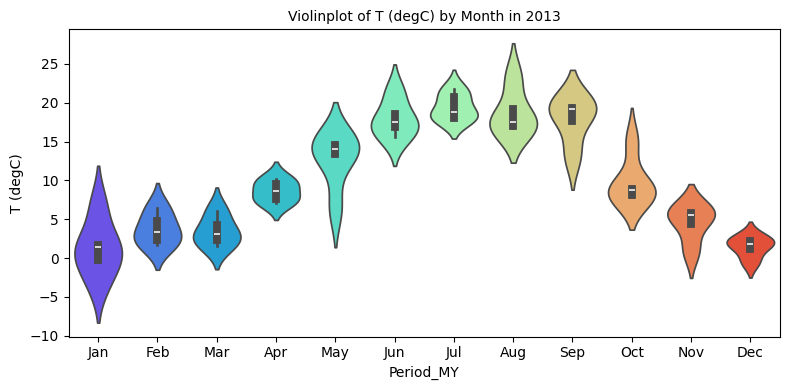

In [909]:
# For ease of visualization, we can then use dt.strftime() to convert to Index using specified date_format. It returns an Index of formatted strings.
plt.figure(figsize=(8,4))
sns.violinplot(x=weather_df_2016['Period_MY'].dt.strftime('%b'),y = weather_df_2016['T (degC)'], palette='rainbow')
plt.title('Violinplot of T (degC) by Month in 2013', fontsize=10)
plt.tight_layout()
plt.show()

### Histograms

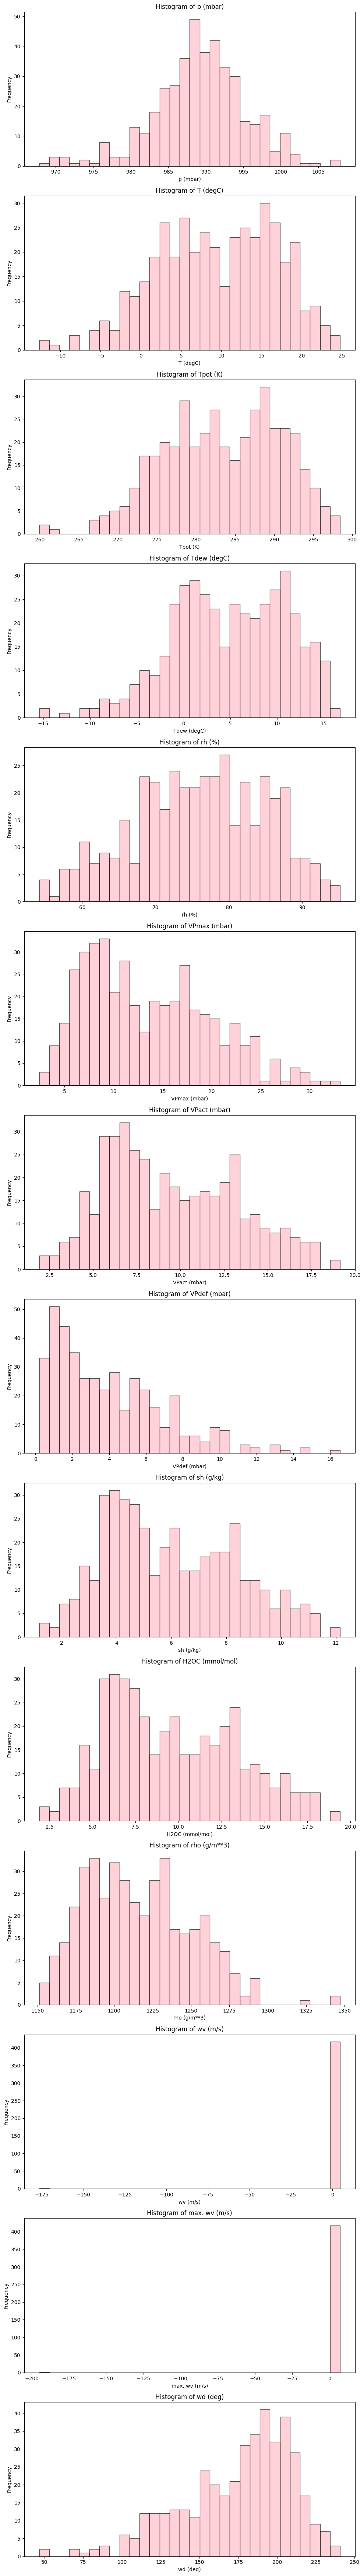

In [910]:
fig, axes = plt.subplots(len(weather_df_weekly.columns), 1, figsize=(10, len(weather_df_weekly.columns) * 5))
for i, column in enumerate(weather_df_weekly.columns):
    ax = axes[i] if len(weather_df_weekly.columns) > 1 else axes
    ax.hist(weather_df_weekly[column].dropna(), bins=30, color='pink', edgecolor='black', alpha=0.7)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Outliers

**IQR**

1. Calculate the 3rd quartile and the 1st quartile.
2. Compute the IQR as the difference between 3rd quartile and the 1st quartile. 
3. Find the upper and lower limits.

In [911]:
for column in weather_df_weekly.columns:
    Q1_py = np.quantile(weather_df_weekly[column],0.25)
    Q3_py = np.quantile(weather_df_weekly[column],0.75)
    IQR = Q3_py-Q1_py
    Lower = Q1_py - 1.5*IQR
    Upper = Q3_py + 1.5*IQR

    T = []
    for i in weather_df_weekly[column]:
        exp1 = i < Lower
        exp2 = i > Upper
        if exp1 or exp2:
            temp = int(i)
            T.append(temp)
    print('Column ', column, 'has the outliers', T)

Column  p (mbar) has the outliers [970, 971, 974, 971, 973, 970, 967, 974, 1004, 1007, 971, 973, 970, 1007]
Column  T (degC) has the outliers []
Column  Tpot (K) has the outliers [260, 259]
Column  Tdew (degC) has the outliers [-15, -15]
Column  rh (%) has the outliers []
Column  VPmax (mbar) has the outliers [33]
Column  VPact (mbar) has the outliers []
Column  VPdef (mbar) has the outliers [13, 12, 13, 12, 16, 14, 14]
Column  sh (g/kg) has the outliers []
Column  H2OC (mmol/mol) has the outliers []
Column  rho (g/m**3) has the outliers [1327, 1340, 1347]
Column  wv (m/s) has the outliers [4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, -176, 3, 3, 3, 3]
Column  max. wv (m/s) has the outliers [7, 6, 7, 5, 6, 5, -194, 5, 5]
Column  wd (deg) has the outliers [46, 71, 75, 69, 53]


**Standard deviation**
1. Calculate the average and standard deviation of the data set.
2. Determine if any results are greater than +/- 3 times the standard deviation. 
3. Find the upper and lower limits.

In [912]:
for column in weather_df_weekly.columns:
    mean_value = np.mean(weather_df_weekly[column])
    sd_value = np.std(weather_df_weekly[column])
    thr = 3*sd_value
    Lower = mean_value - thr
    Upper = mean_value + thr

    outliers = [i for i in weather_df_weekly[column] if i < Lower or i > Upper]
    print('Column ', column, 'has', len(outliers), 'outliers')

Column  p (mbar) has 5 outliers
Column  T (degC) has 0 outliers
Column  Tpot (K) has 2 outliers
Column  Tdew (degC) has 2 outliers
Column  rh (%) has 0 outliers
Column  VPmax (mbar) has 1 outliers
Column  VPact (mbar) has 0 outliers
Column  VPdef (mbar) has 5 outliers
Column  sh (g/kg) has 0 outliers
Column  H2OC (mmol/mol) has 0 outliers
Column  rho (g/m**3) has 3 outliers
Column  wv (m/s) has 1 outliers
Column  max. wv (m/s) has 1 outliers
Column  wd (deg) has 2 outliers


In [913]:
weather_df_weekly_no_outliers = weather_df_weekly.copy()
outlier_indices = set()

for column in weather_df_weekly_no_outliers.columns:
    mean_value = np.mean(weather_df_weekly_no_outliers[column])
    sd_value = np.std(weather_df_weekly_no_outliers[column])
    thr = 3 * sd_value
    Lower = mean_value - thr
    Upper = mean_value + thr

    column_outliers = weather_df_weekly_no_outliers[(weather_df_weekly_no_outliers[column] < Lower) | (weather_df_weekly_no_outliers[column] > Upper)].index
    outlier_indices.update(column_outliers)

weather_df_weekly_no_outliers = weather_df_weekly_no_outliers.drop(index=outlier_indices)

In [914]:
weather_df_weekly_no_outliers

p (mbar)  T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                               
2009-01-04   996.446696 -4.292070  269.146087    -6.185148  87.255409   
2009-01-18   991.308760 -1.717867  272.126657    -4.664692  81.310595   
2009-02-08   971.686974  0.732718  276.155179    -1.741111  84.228452   
2009-02-15   984.736240 -1.161835  273.211210    -4.093373  80.981131   
2009-02-22   995.551796 -1.115556  272.394077    -3.056200  87.228899   
...                 ...       ...         ...          ...        ...   
2016-11-27   990.392619  5.460387  279.395804     3.199931  86.493690   
2016-12-04   999.956121 -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891  1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288  2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817  1.969593  275.060228    -0.343909  85.042927   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-02-08      6.572510      5.429990      1.142688   3.485317   
2009-02-15      5.715883      4.585575      1.130030   2.907897   
2009-02-22      5.766875      5.059494      0.707619   3.168929   
...                  ...           ...           ...        ...   
2016-11-27      9.255060      7.784315      1.470665   4.904573   
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-02-08         5.591171   1233.436716  1.311359       2.295347  179.457460  
2009-02-15         4.666458   1259.230774  2.662411       4.434444  214.667540  
2009-02-22         5.084345   1272.602163  1.908879       3.236617  198.556994  
...                     ...           ...       ...            ...         ...  
2016-11-27         7.861250   1234.875308  1.774157       2.837054  152.135645  
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  

[402 rows x 14 columns]

#### Plots without outliers

##### Line plots

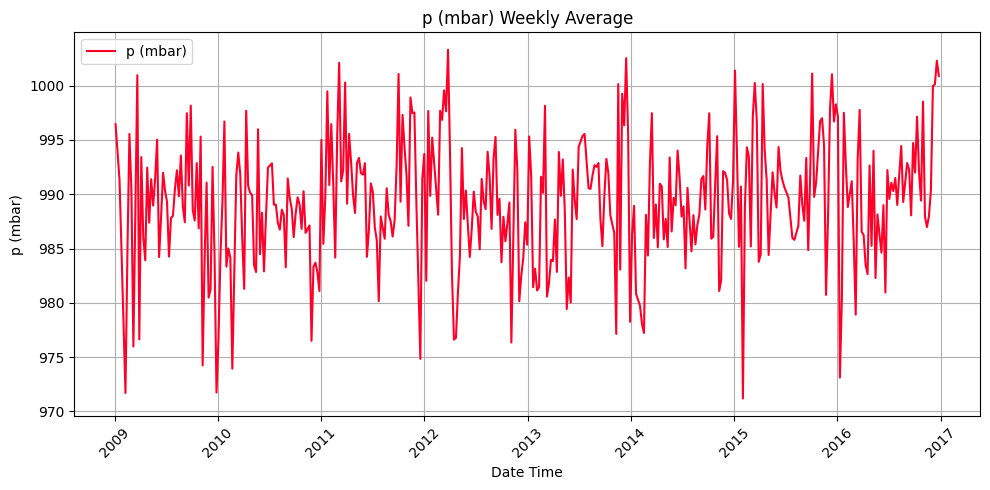

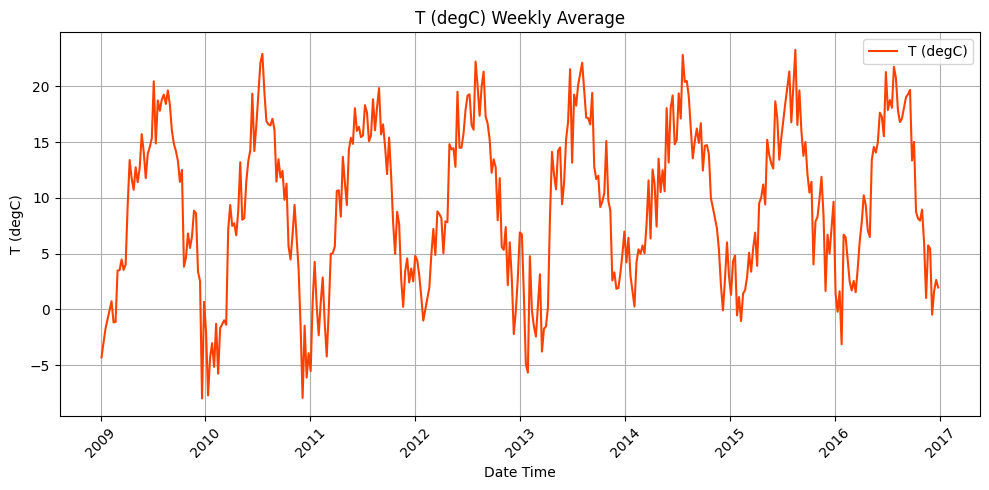

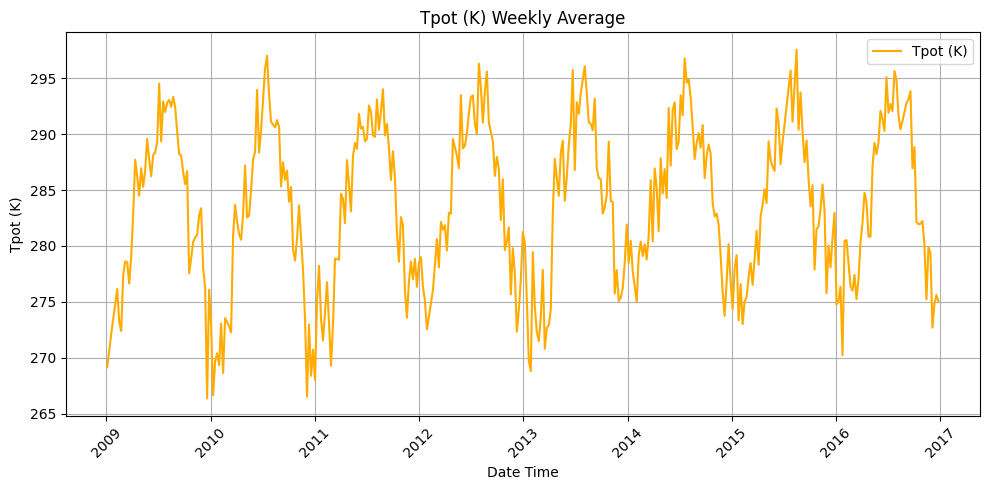

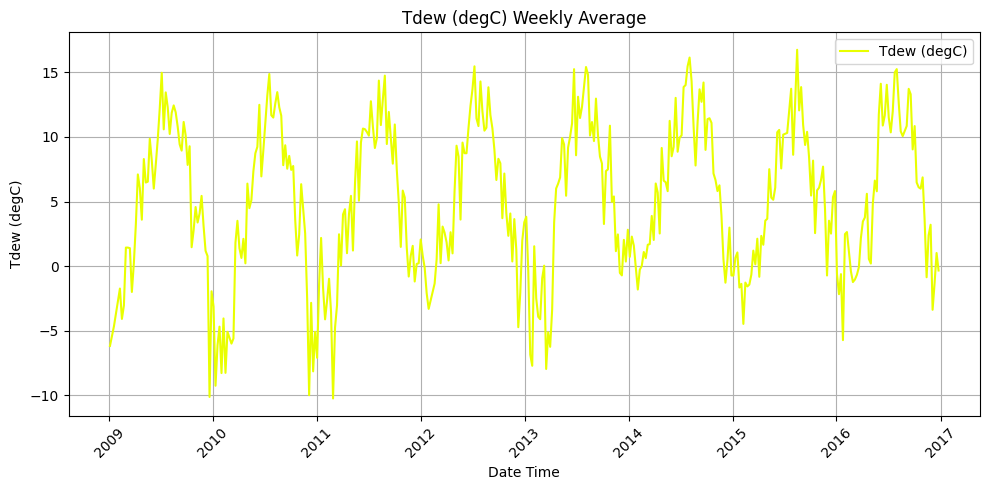

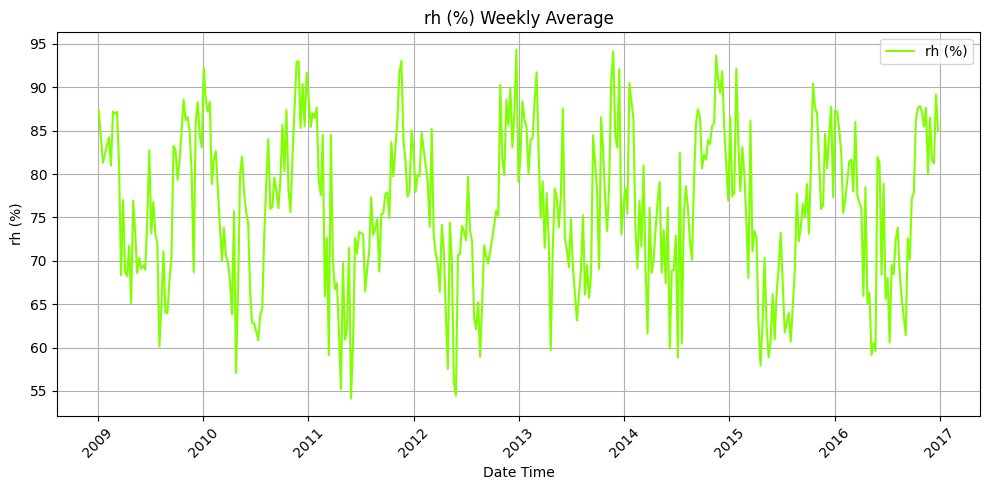

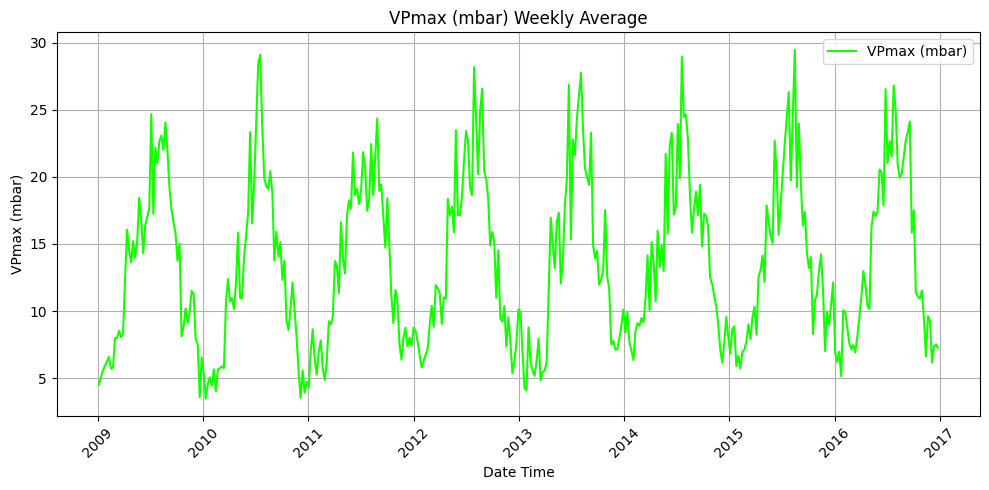

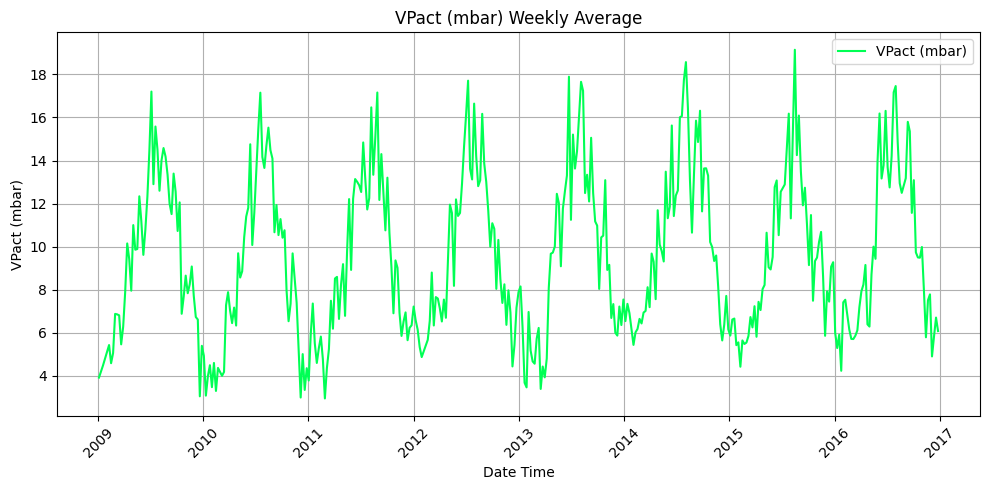

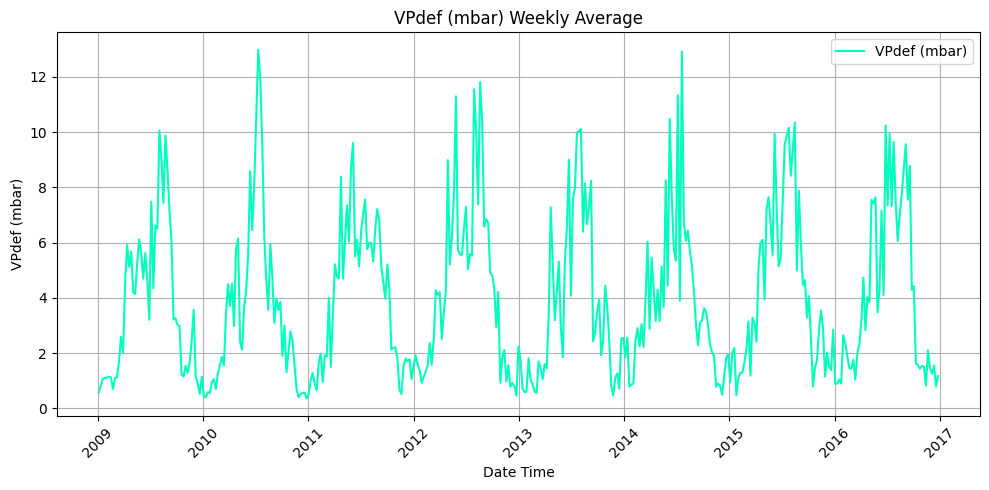

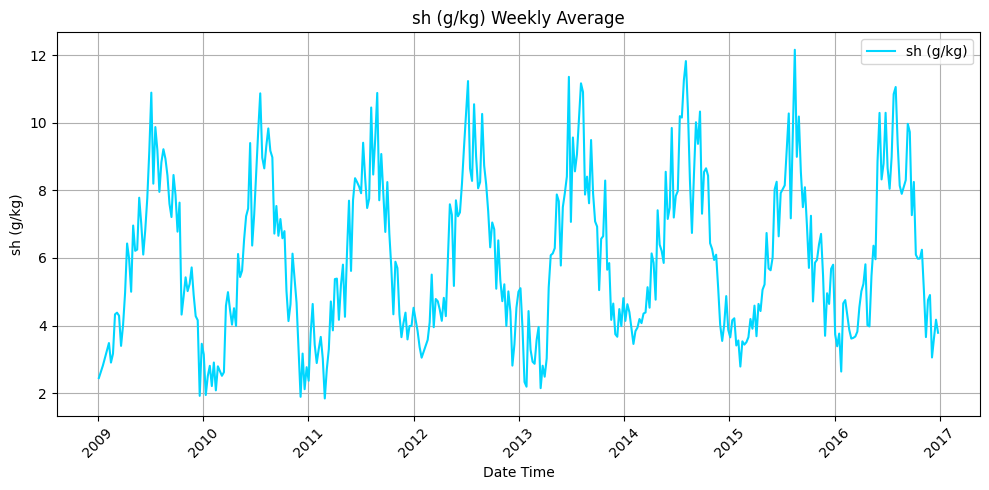

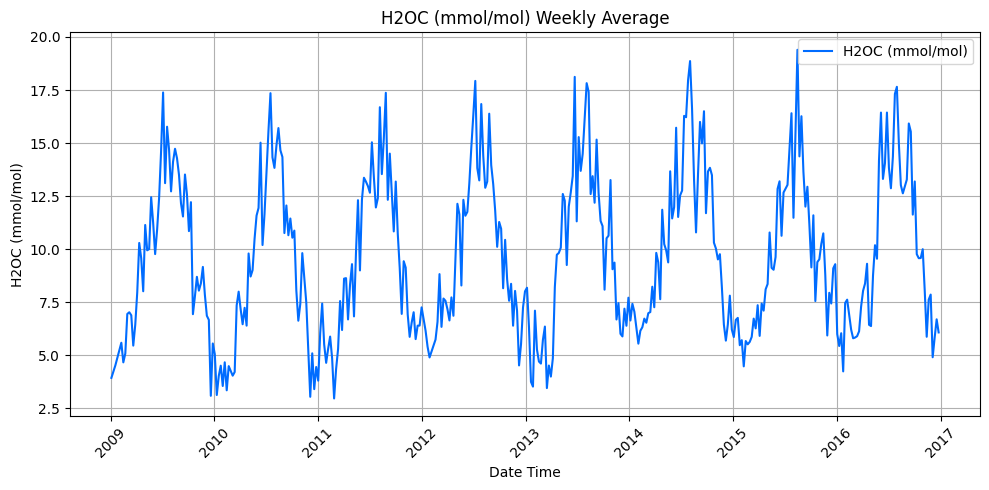

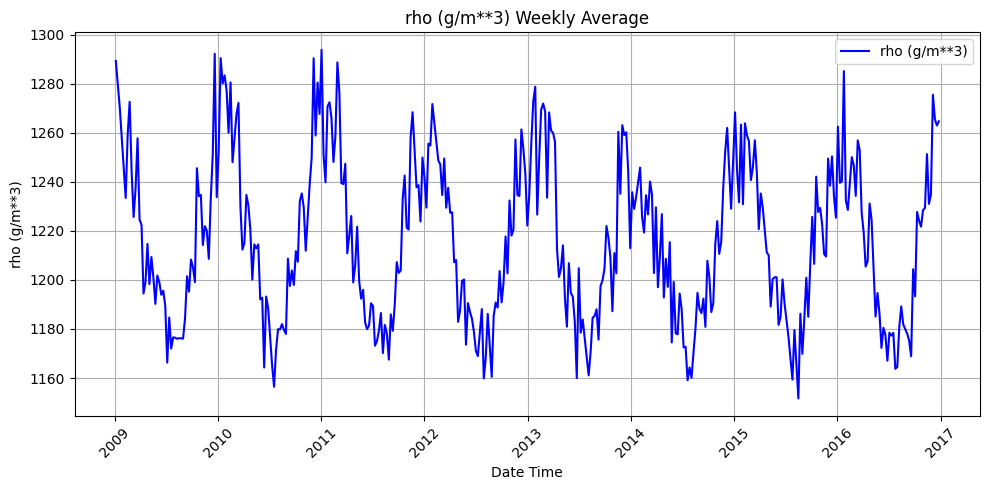

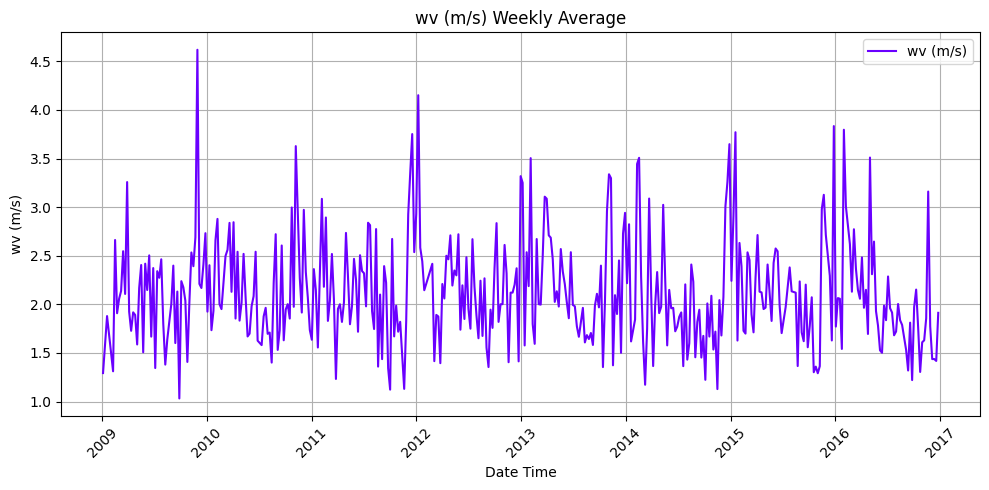

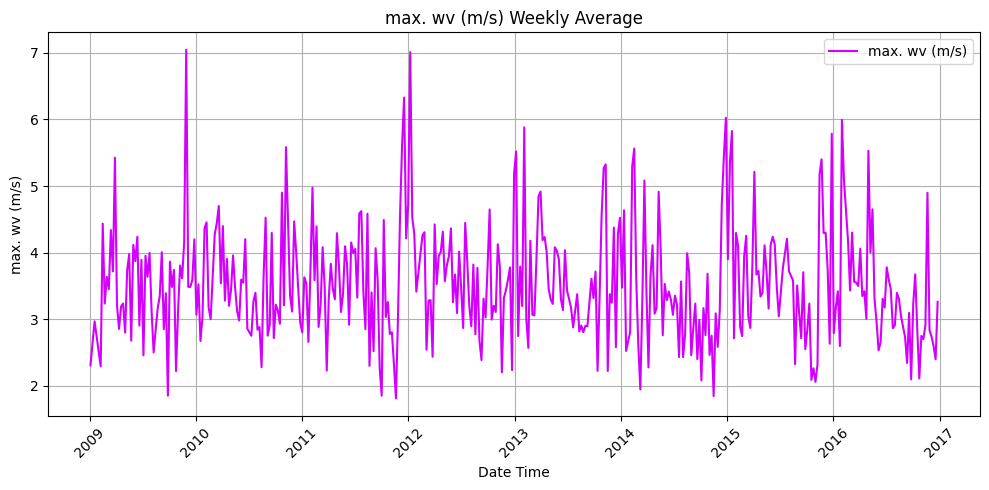

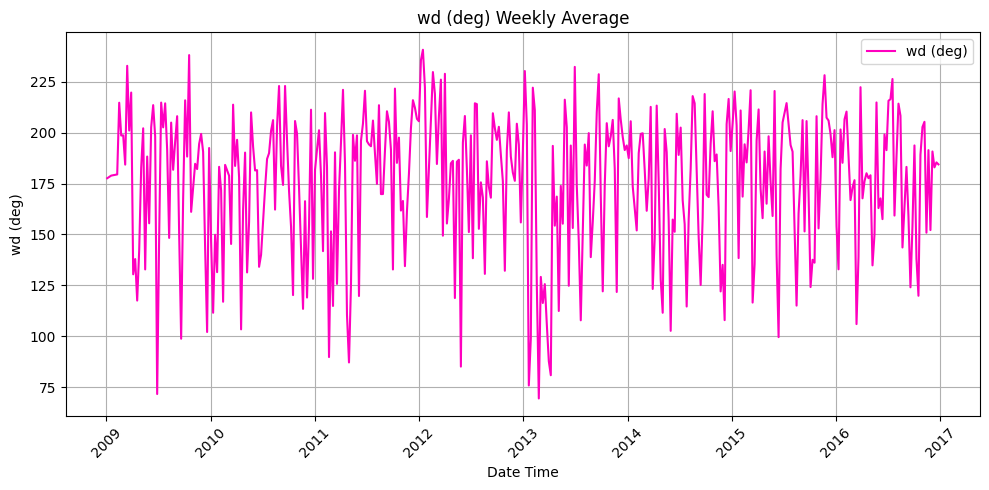

In [915]:
for colore, column in enumerate(columns):
    plt.figure(figsize=(10, 5))
    plt.plot(weather_df_weekly_no_outliers.index, weather_df_weekly_no_outliers[column], label=column, color=cmap(colore))
    plt.title(f'{column} Weekly Average')
    plt.xlabel('Date Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### Box plots

In [916]:
# Add one colum to indicate the year (DatetimeIndex -> PeriodIndex)
weather_df_weekly_period = weather_df_weekly_no_outliers.copy()
weather_df_weekly_period['Period_Y'] = weather_df_weekly_period.index.to_period('Y')
weather_df_weekly_period.head(5)

p (mbar)  T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                              
2009-01-04  996.446696 -4.292070  269.146087    -6.185148  87.255409   
2009-01-18  991.308760 -1.717867  272.126657    -4.664692  81.310595   
2009-02-08  971.686974  0.732718  276.155179    -1.741111  84.228452   
2009-02-15  984.736240 -1.161835  273.211210    -4.093373  80.981131   
2009-02-22  995.551796 -1.115556  272.394077    -3.056200  87.228899   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-02-08      6.572510      5.429990      1.142688   3.485317   
2009-02-15      5.715883      4.585575      1.130030   2.907897   
2009-02-22      5.766875      5.059494      0.707619   3.168929   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                            
2009-01-04         3.934887   1289.293165  1.293252       2.310504   
2009-01-18         4.526012   1270.352133  1.879524       2.970417   
2009-02-08         5.591171   1233.436716  1.311359       2.295347   
2009-02-15         4.666458   1259.230774  2.662411       4.434444   
2009-02-22         5.084345   1272.602163  1.908879       3.236617   

              wd (deg) Period_Y  
Date Time                        
2009-01-04  177.589652     2009  
2009-01-18  178.882599     2009  
2009-02-08  179.457460     2009  
2009-02-15  214.667540     2009  
2009-02-22  198.556994     2009

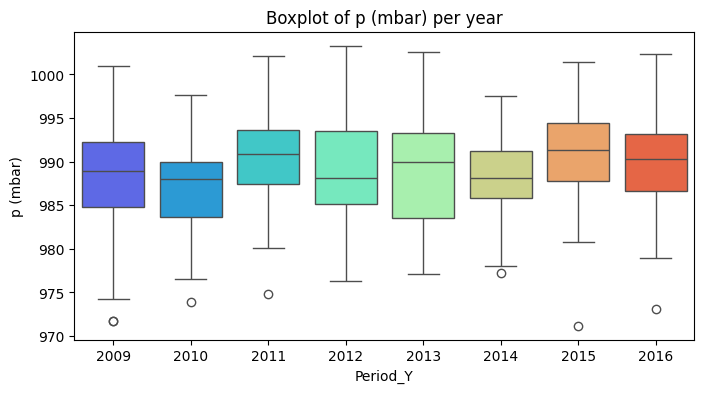

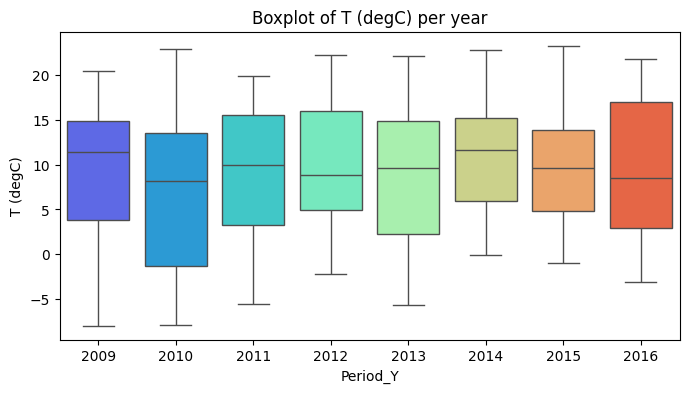

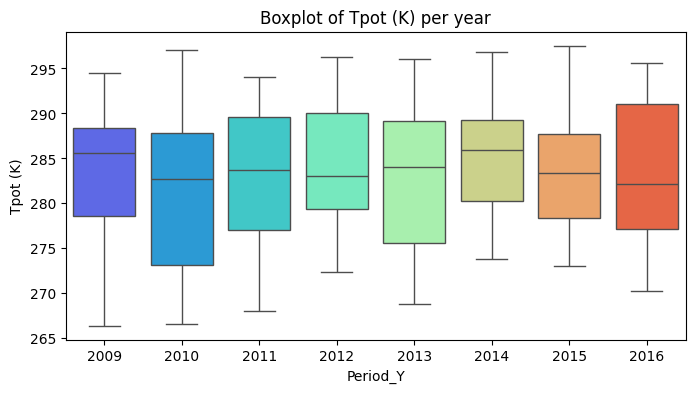

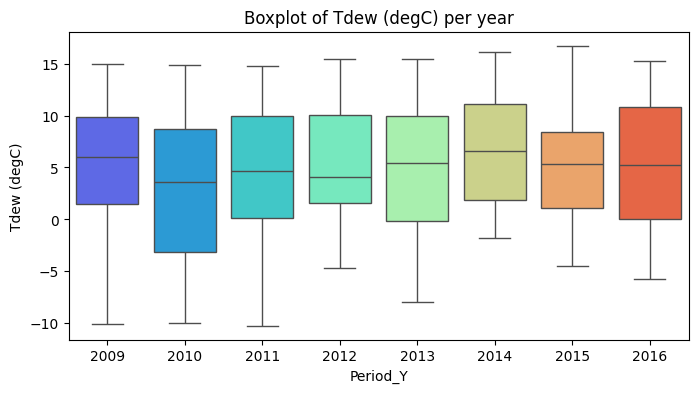

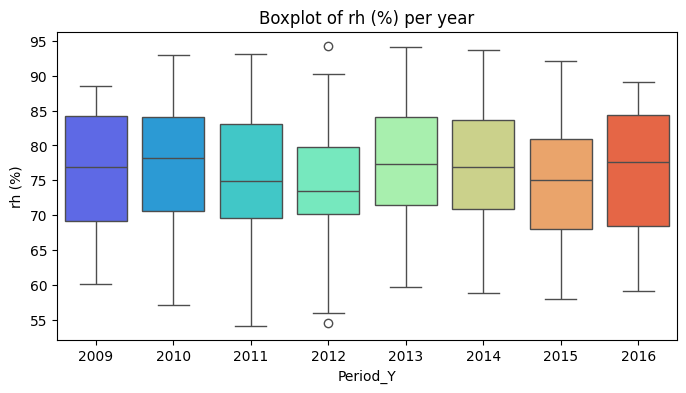

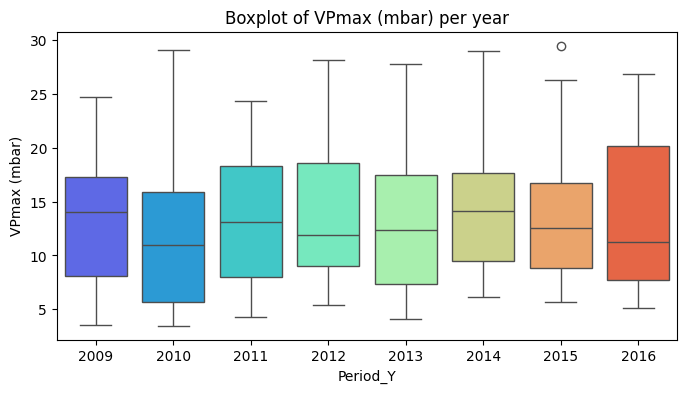

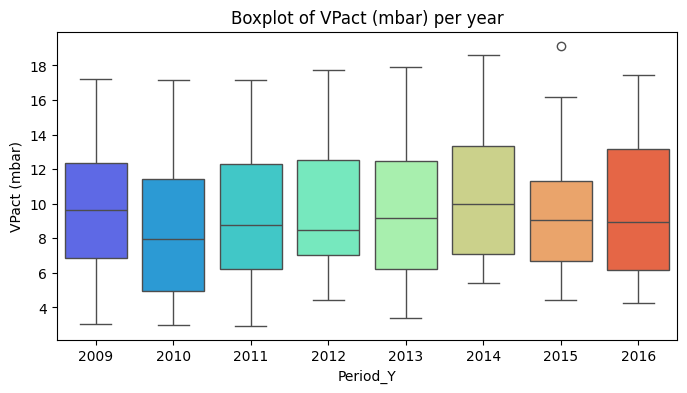

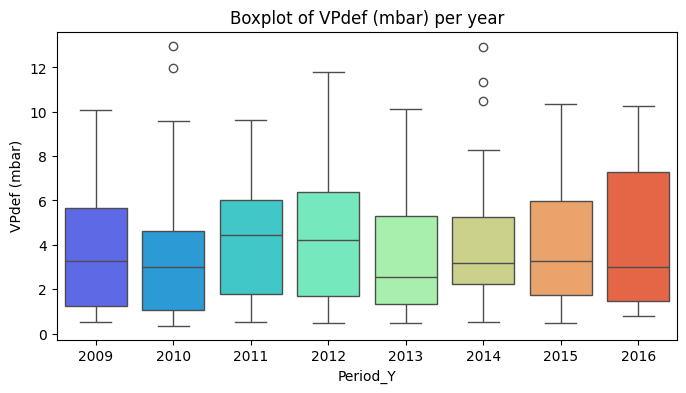

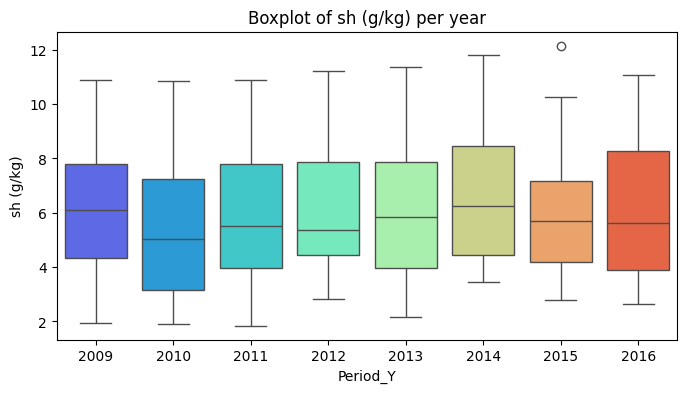

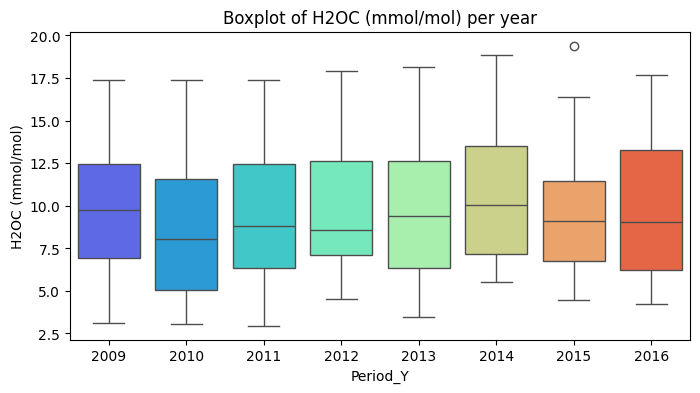

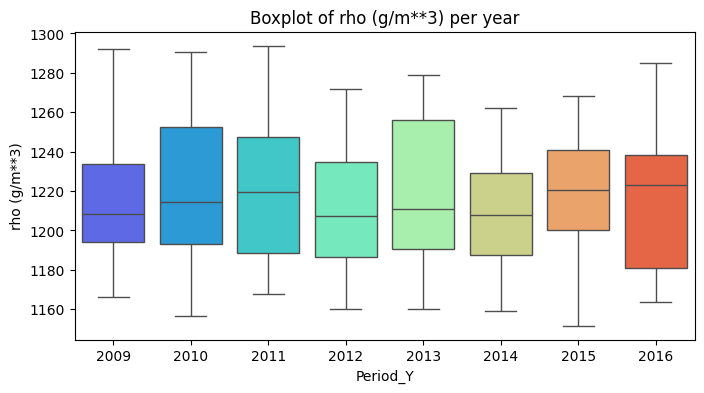

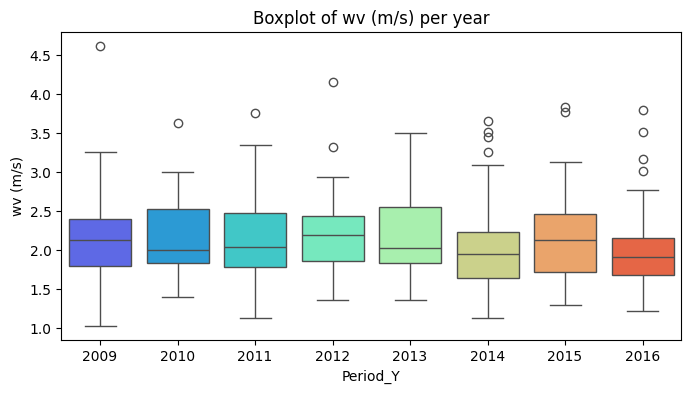

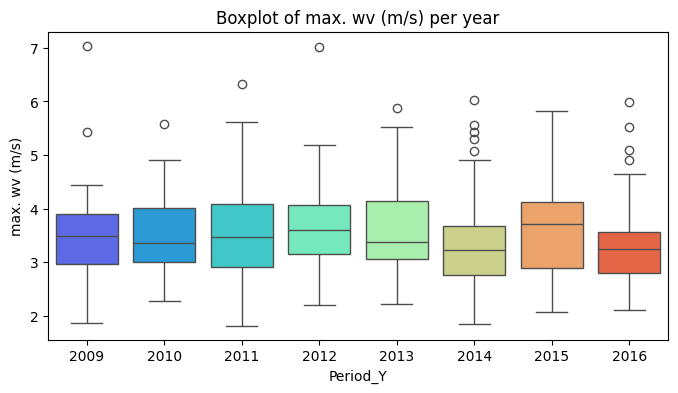

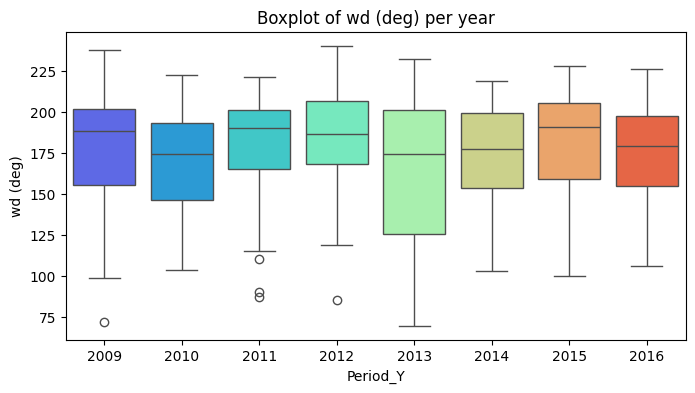

In [917]:
for column in weather_df_weekly_period.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8,4))
    plt.title('Boxplot of ' + column + ' per year')
    sns.boxplot(x = weather_df_weekly_period['Period_Y'], y = weather_df_weekly_period[column], palette='rainbow')
    plt.show()

##### Violin plots

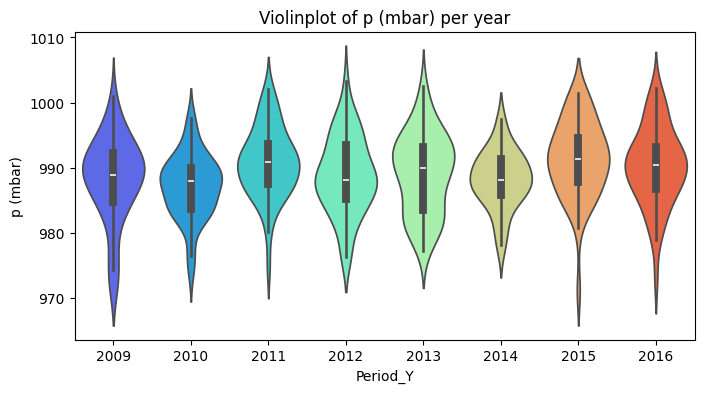

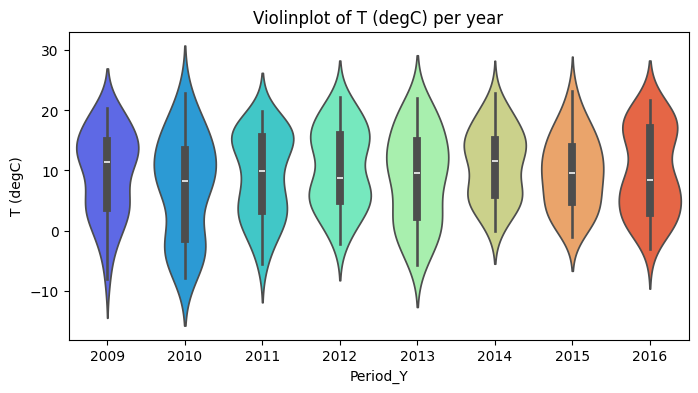

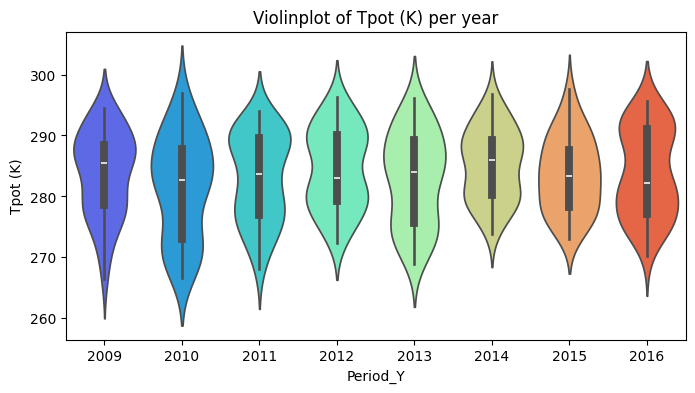

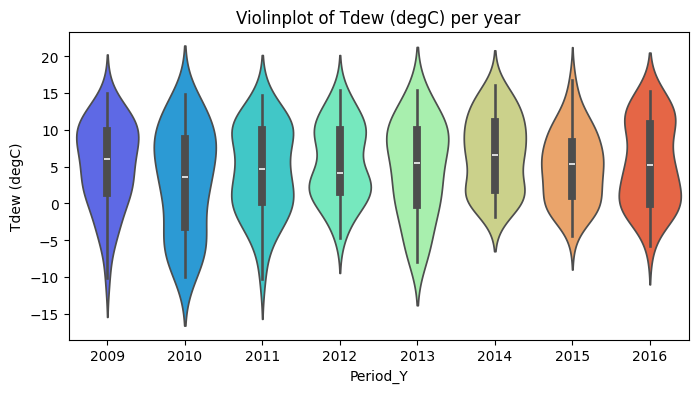

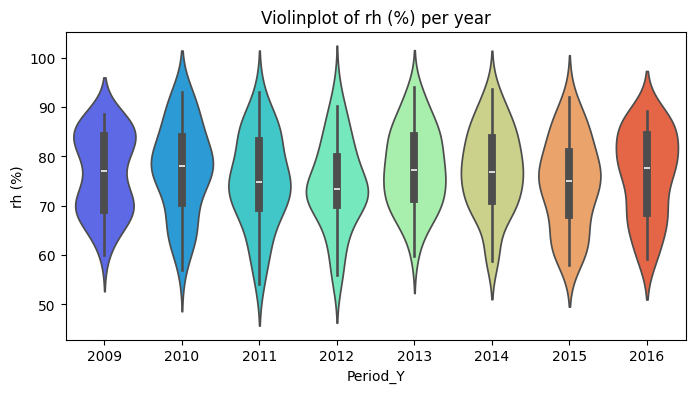

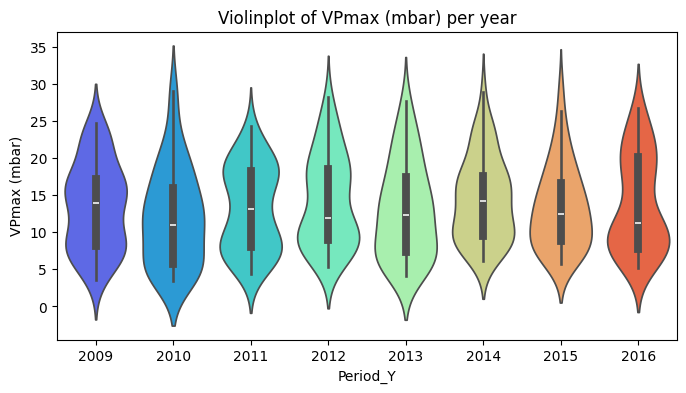

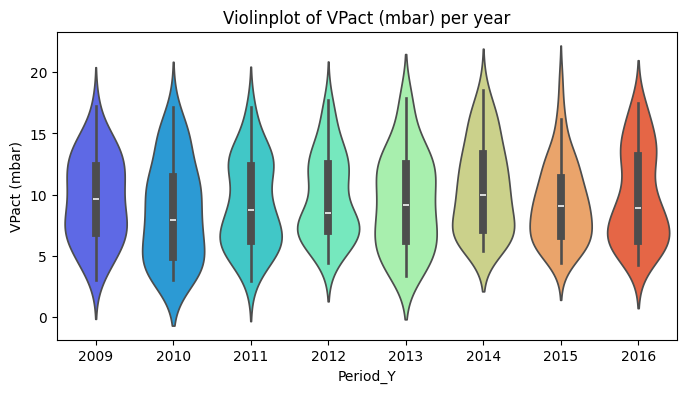

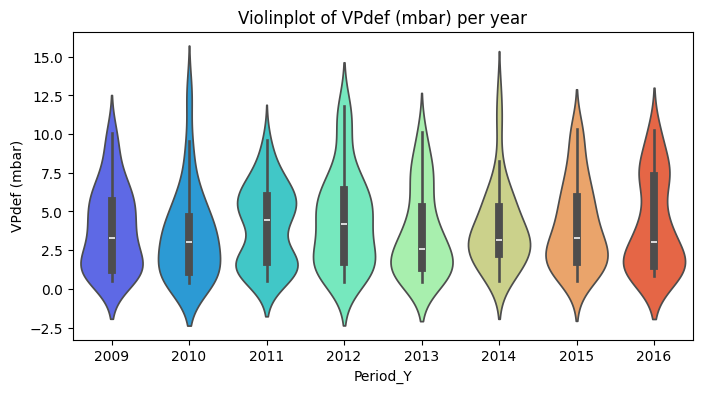

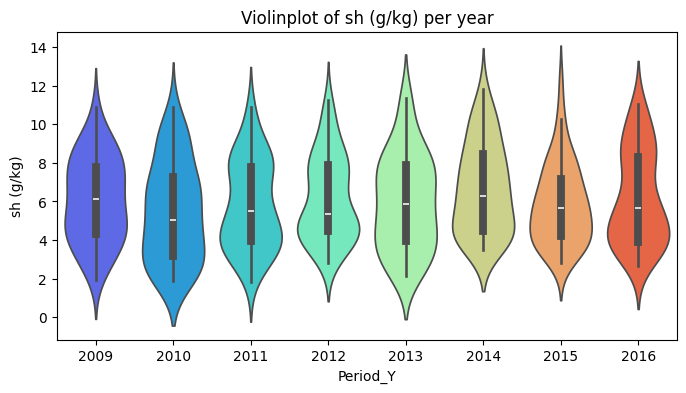

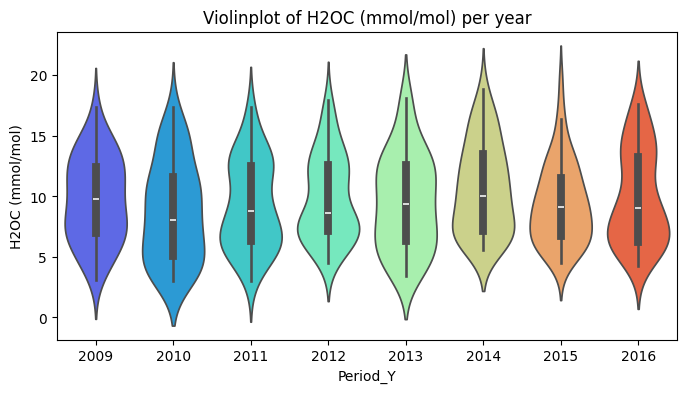

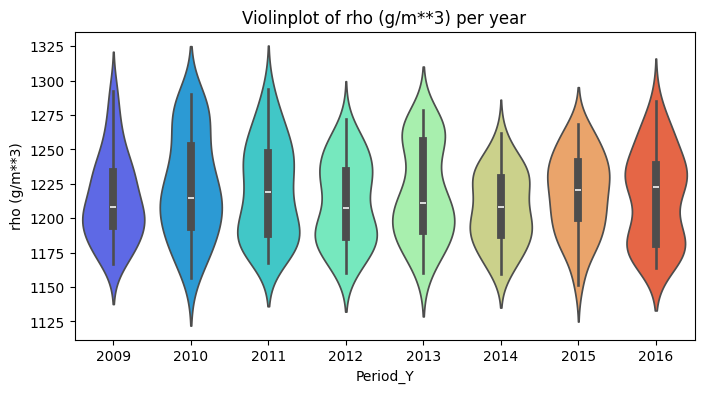

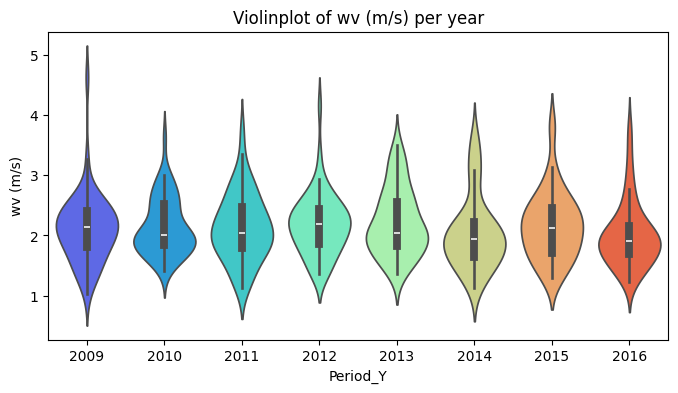

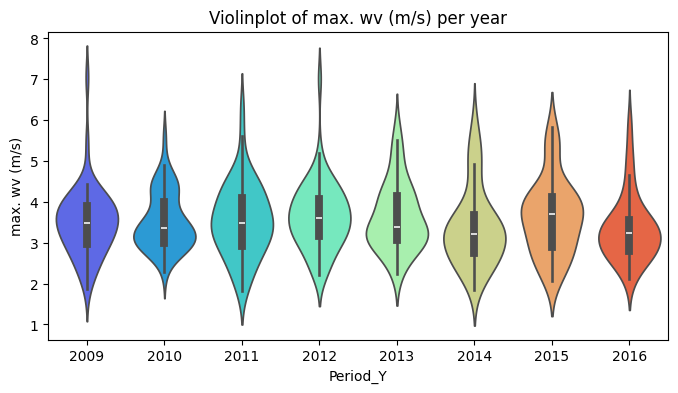

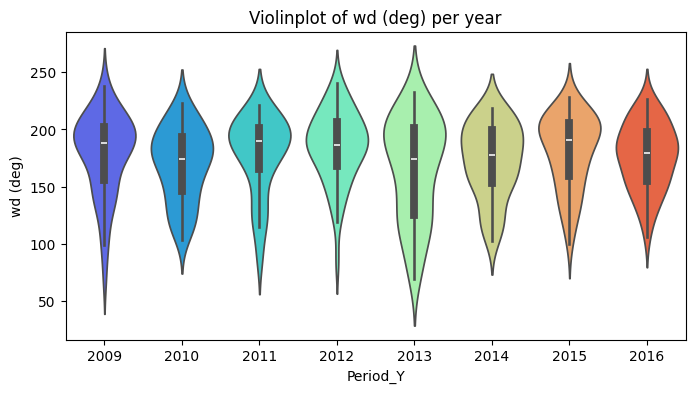

In [918]:
for column in weather_df_weekly_period.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8,4))
    plt.title('Violinplot of ' + column + ' per year')
    sns.violinplot(x = weather_df_weekly_period['Period_Y'], y = weather_df_weekly_period[column], palette='rainbow')
    plt.show()

##### Histograms

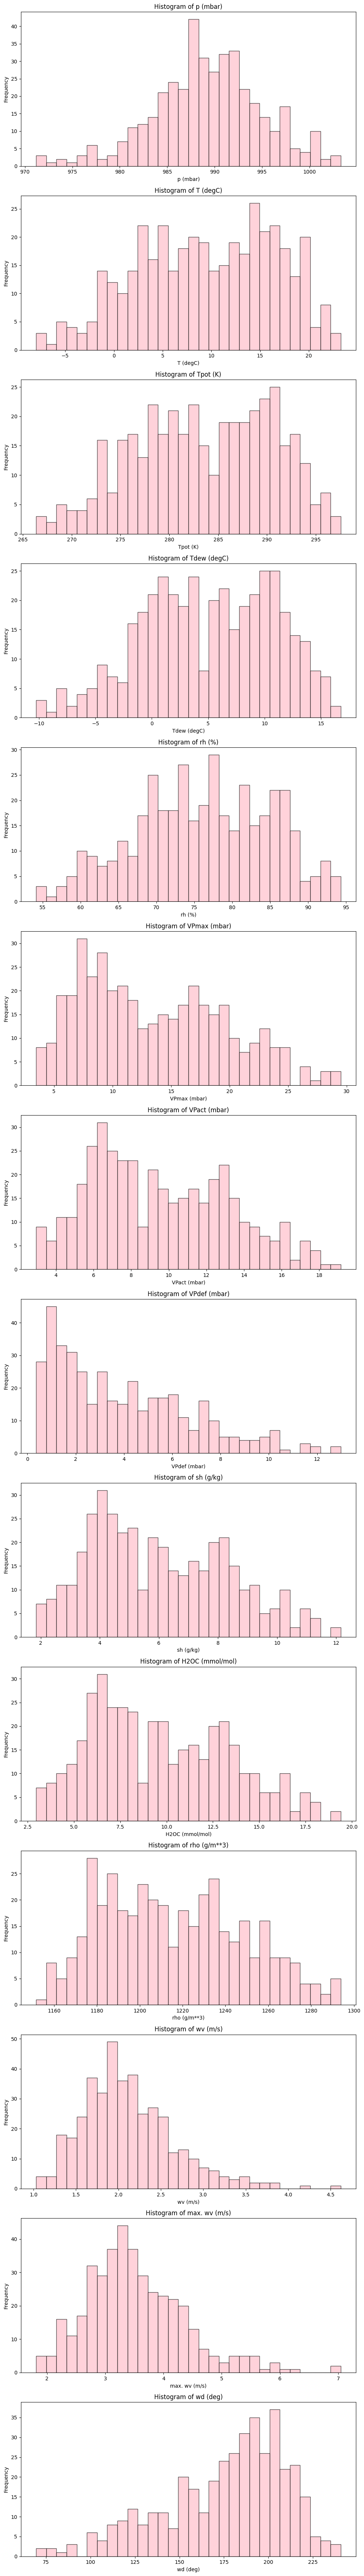

In [919]:
fig, axes = plt.subplots(len(weather_df_weekly_no_outliers.columns), 1, figsize=(10, len(weather_df_weekly_no_outliers.columns) * 5))
for i, column in enumerate(weather_df_weekly_no_outliers.columns):
    ax = axes[i] if len(weather_df_weekly_no_outliers.columns) > 1 else axes
    ax.hist(weather_df_weekly_no_outliers[column].dropna(), bins=30, color='pink', edgecolor='black', alpha=0.7)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Frequency analysis
Using PSD

Freq     Period         Power
0  0.019139  52.250000  18899.406162
1  0.031100  32.153846    117.468199
2  0.066986  14.928571    129.502714
3  0.098086  10.195122    122.711814

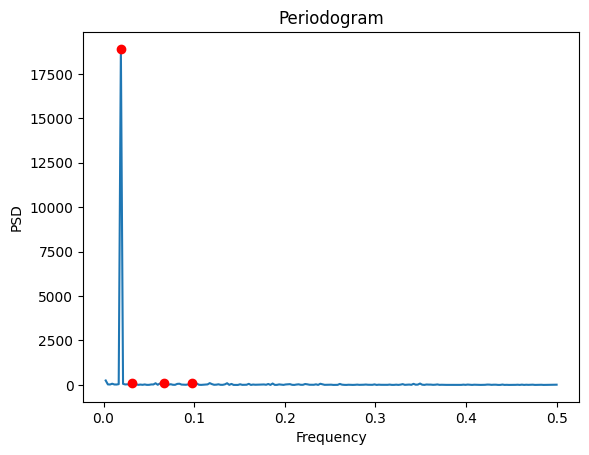

In [920]:
Fs = 1
f_per, Pxx_per = signal.periodogram(weather_df_weekly['T (degC)'],Fs,detrend=None,window='boxcar',return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
period_peak = 1/peak_freq
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.title('Periodogram')

data = {'Freq': peak_freq, 'Period': period_peak, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

First peak is 52 -> confirms m=52 (m=7 when 365 days, m=4 whit quarters, etc.): there is a yearly seasonality.

Total sum Density: 22849.446182824253
Frequency for the maximum value (Welch) is:  0.019138755980861243
Period (weeks/cycle):  52.25
Total sum Density: 23030.141851199365
Frequency for the maximum value is:  0.019138755980861243
Period (weeks/cycle):  52.25


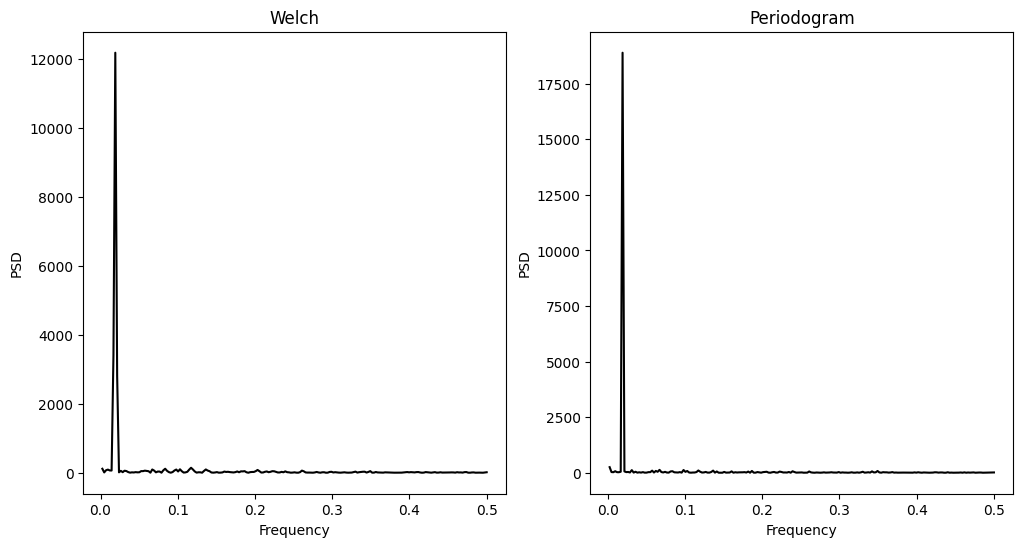

In [921]:
# Use Welch's and classic periodogram for PSD calculations. Found the frequency corresponding to the max value with these two methods
win = len(weather_df_weekly)
f_welch_density, Pxx_welch_density = signal.welch(weather_df_weekly['T (degC)'],Fs, window='hann', noverlap=None, nperseg=win, return_onesided=True, scaling='density')
f_welch_density = f_welch_density[1:]
Pxx_welch_density = Pxx_welch_density[1:]

f_per_density, Pxx_per_density = signal.periodogram(weather_df_weekly['T (degC)'],Fs,detrend=False,window=None,nfft=None,return_onesided=True,scaling='density')
f_per_density = f_per_density[1:]
Pxx_per_density = Pxx_per_density[1:]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(f_welch_density, Pxx_welch_density,'k')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('PSD')
ax[0].set_title('Welch')

ax[1].plot(f_per_density, Pxx_per_density,'k')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('PSD')
ax[1].set_title('Periodogram')

P_welch = np.sum(Pxx_welch_density)
print('Total sum Density:', P_welch)
temp_welch = np.where(Pxx_welch_density == Pxx_welch_density.max())
print('Frequency for the maximum value (Welch) is: ',float(f_welch_density[temp_welch]))
print('Period (weeks/cycle): ',float(1/f_welch_density[temp_welch]))

P_per = np.sum(Pxx_per_density)
print('Total sum Density:', P_per)
temp_per = np.where(Pxx_per_density == Pxx_per_density.max())
print('Frequency for the maximum value is: ',float(f_per_density[temp_per]))
print('Period (weeks/cycle): ',float(1/f_per_density[temp_per]))

By definition, the Frequency can be found by doing 1/T. We know that our period is around 52 (more precisely 52,1429). Therefore, since T=1/F, we compute:

<center>T = 1/0.01915 = 52,...</center>

Ergo

<center>m = 52</center>

Confirms a periodicity of 52 weeks.

## **Point 3**
Describing the time series patterns (visually and numerically).

In [922]:
train_temp = train['T (degC)']
test_temp = test['T (degC)']

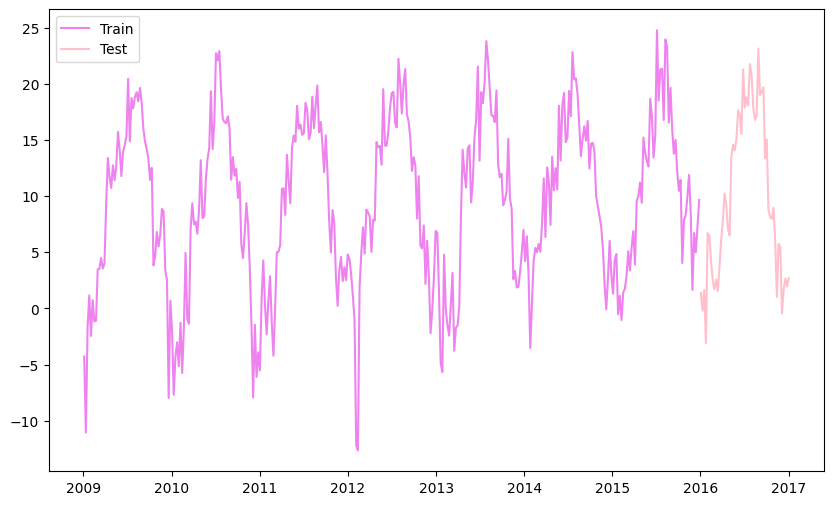

In [923]:
plt.figure(figsize=(10,6))
plt.plot(train_temp, color = 'violet', label='Train')
plt.plot(test_temp, color='pink', label='Test')
plt.legend()
plt.show()

### Decomposition

#### Classical

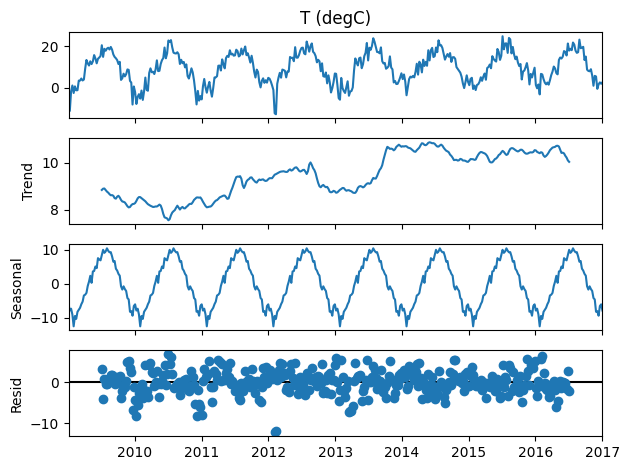

In [924]:
decompose_data_add = seasonal_decompose(weather_df_weekly['T (degC)'], model='additive', period = 52) # period is automatically set to 12, considering the monthly data
decompose_data_add.plot()
plt.show()

The "trend" line shows an increase of the temperature over time, probably due to climate change. The "seasonal line" clearly confirms the annual seasonality of the data.

Anothere way to visualize the residuals of additive decomposition:

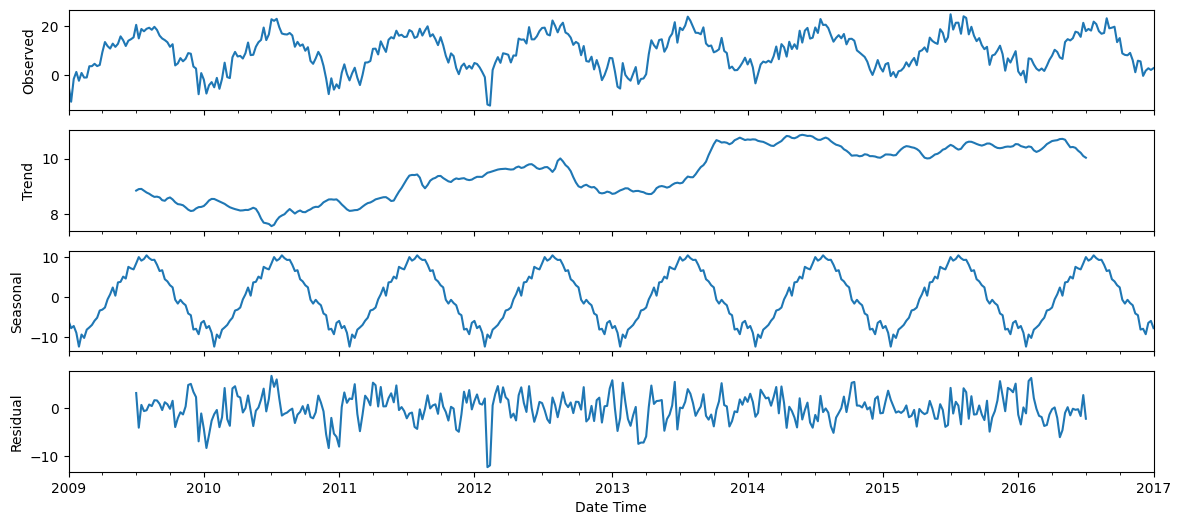

In [925]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14,6))
plotseasonal(decompose_data_add, axes)

The multiplicative model is not good due to the fact that the column has negative values.

#### STL

In [926]:
stl = STL(train_temp, seasonal=7, robust = True)
res = stl.fit()
stl.config # To check the main parameters of the decomposition

{'period': 52,
 'seasonal': 7,
 'seasonal_deg': 1,
 'seasonal_jump': 1,
 'trend': 101,
 'trend_deg': 1,
 'trend_jump': 1,
 'low_pass': 53,
 'low_pass_deg': 1,
 'low_pass_jump': 1,
 'robust': True}

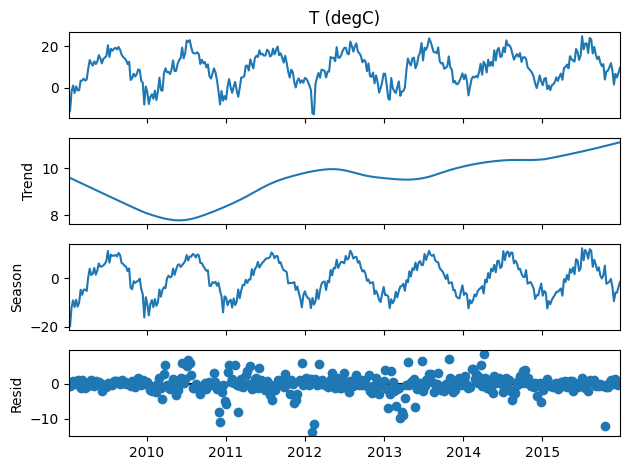

In [927]:
res.plot()
plt.show()

### Stationarity

In order to check for the **stationarity of a time series**, different operations and statistical tests can be done, in particular:
- Evaluating rolling statistics (generally mean and standard deviation) -> it should be constant each year;
- ACF plot: for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly;
- Unit root tests: these are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests are the main ones.

#### Rolling statistics

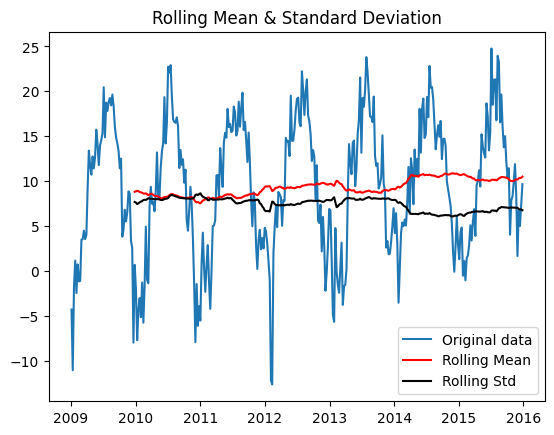

In [928]:
# Rolling statistics
rolling_mean = train_temp.rolling(52).mean()
rolling_std = train_temp.rolling(52).std()
plt.plot(train_temp, label='Original data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Rolling mean and std do not have a constant behaviour over the years, this hints towards non-stationarity.

#### ACF

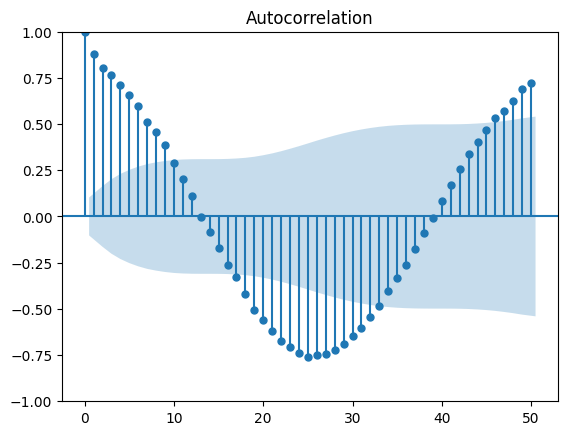

In [929]:
plot_acf(train_temp, lags=50)
plt.show()

If the series were stationary, the autocorrelations would drop to near zero quickly, but that is not really the case. The periodic nature of the autocorrelations confirms the seasonality of the data. 

#### ADF and KPSS

In [930]:
# Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

adfuller_test(train_temp)

ADF Statistic: -7.945514086336796
p-value:  3.2279831966227972e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary


In [931]:
# Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')
kpss_test(train_temp)

KPSS Statistic: 0.020274605447635607
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


In [932]:
# Execute a second KPSS test
def kpss_test_2(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')
kpss_test_2(train_temp)

KPSS Statistic: 0.10545784665825465
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


These two tests are not interchangeble, considering their different assumptions/null hypotheses. It is always better to apply both of them, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- **Case 1**: Both tests conclude that the series is not stationary - The series is not stationary.

- **Case 2**: Both tests conclude that the series is stationary - The series is stationary.

- **Case 3**: KPSS indicates stationarity and ADF indicates non-stationarity -> The series is trend stationary: it requires operations to remove the trend (MIN 21). The resulting detrended series is checked for stationarity.

- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity ->  The series is difference stationary: it requires differencing. The differenced series is checked for stationarity.

We are in case 3, therefore we don't need to differentiate/decompose the data.

## **Point 4**
Focusing on temperature (degC, dependent variable), build the most appropriate models to forecast the
data for the specified period. Evaluate the model performance using different metrics. Visualise the results with appropriate graphs.

I'm focusing on the column T (degC), which, we have seen in the Correlation plot, has an high correlation with the columns:
- (Tpot (K)),
- (Tdew (degC)),
- VPmax (mbar),
- VPact (mbar),
- VPdef (mbar),
- sh (g/kg),
- H2OC (mmol/mol),
- rho (g/m**3) - negative correlation.

Several methods are currently available to forecast portion of data over a period, ranging from simple to more complex approaches each one with its own specific properties/applicability criteria. 

1. **Mean (average) method**: the forecasts of all future values are equal to the  average of the historical data
2.  **Naive method:** all forecasts are set to be equal to the value of the last observation. This method works well for many economic and financial time series. As a naive forecast is optimal when data follow a random walk, these are also called random walk forecasts.
3. **Seasonal naive method:** similar to naive but useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the previous season. For example, with monthly data, the forecast for all future October values is equal to the last observed October value.

#### Mean Method

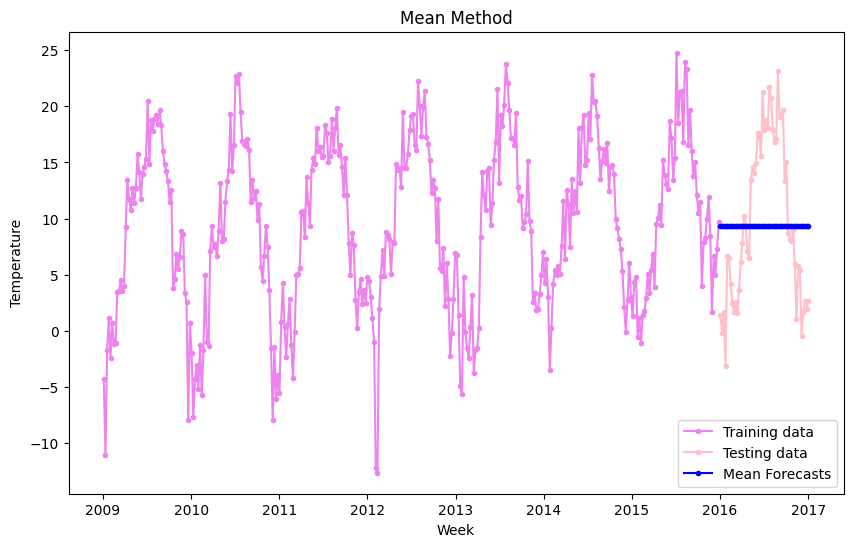

In [933]:
# 1) Mean method --> the forecasts of all future values are equal to the average of the historical data
model = HistoricAverage()
model = model.fit(train_temp)
forecast_values = model.predict(len(test_temp)) # we have to specify the forecasting horizon (i.e., how many points to forecast)

plt.figure(figsize=(10, 6))
plt.plot(train_temp, color='violet',marker = '.',label='Training data')
plt.plot(test_temp, color='pink', marker = '.',label='Testing data')
plt.plot(test_temp.index, forecast_values['mean'], color='blue', marker = '.', label='Mean Forecasts' )
plt.xlabel('Week')
plt.ylabel('Temperature')
plt.title('Mean Method')
plt.legend()
plt.show()

#### Naive Method

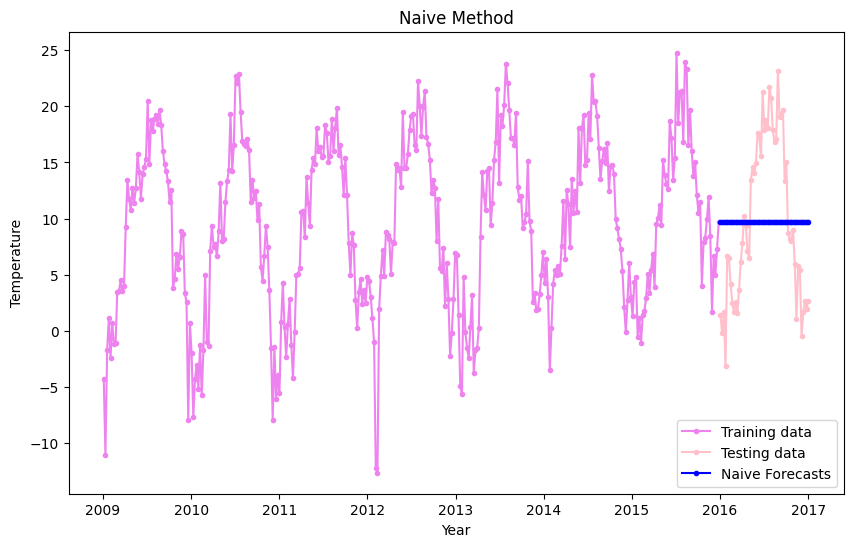

In [934]:
# 2) Naive Method --> we simply set all forecasts to be the value of the last observation
model = Naive()
model = model.fit(train_temp)
forecast_values = model.predict(len(test_temp))

plt.figure(figsize=(10, 6))
plt.plot(train_temp, color='violet',marker = '.',label='Training data')
plt.plot(test_temp, color='pink', marker = '.',label='Testing data')
plt.plot(test_temp.index, forecast_values['mean'], color='blue', marker = '.', label='Naive Forecasts' )
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Naive Method')
plt.legend()
plt.show()

#### Seasonal Naive Method

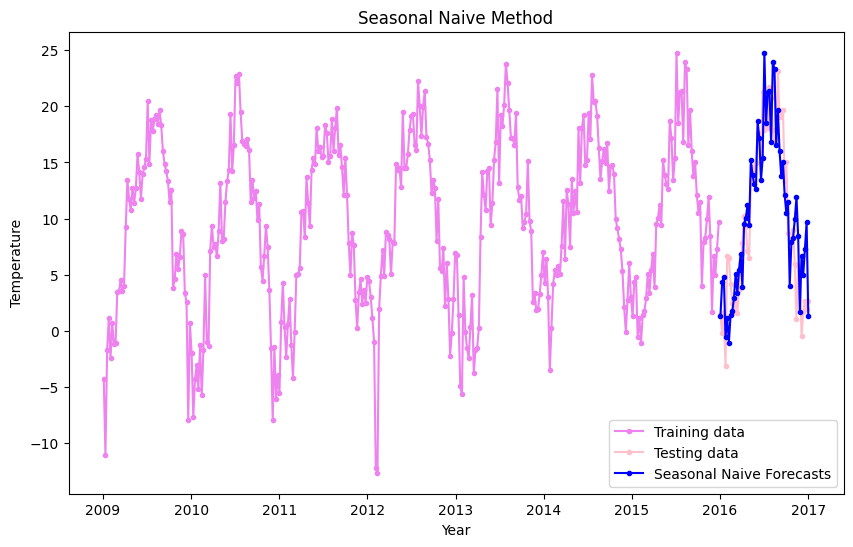

In [935]:
# 3) Seasonal Naive Method --> similar to the naive, but uses the last known observation of the same period
model = SeasonalNaive(season_length=52) # seasonality has to be specified
model = model.fit(train_temp)
forecast_values = model.predict(len(test_temp))

plt.figure(figsize=(10, 6))
plt.plot(train_temp, color='violet',marker = '.',label='Training data')
plt.plot(test_temp, color='pink', marker = '.',label='Testing data')
plt.plot(test_temp.index, forecast_values['mean'], color='blue', marker = '.', label='Seasonal Naive Forecasts' )
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Seasonal Naive Method')
plt.legend()
plt.show()

The Seasonal Naive Method seems to be the most accurate one of the three methods.

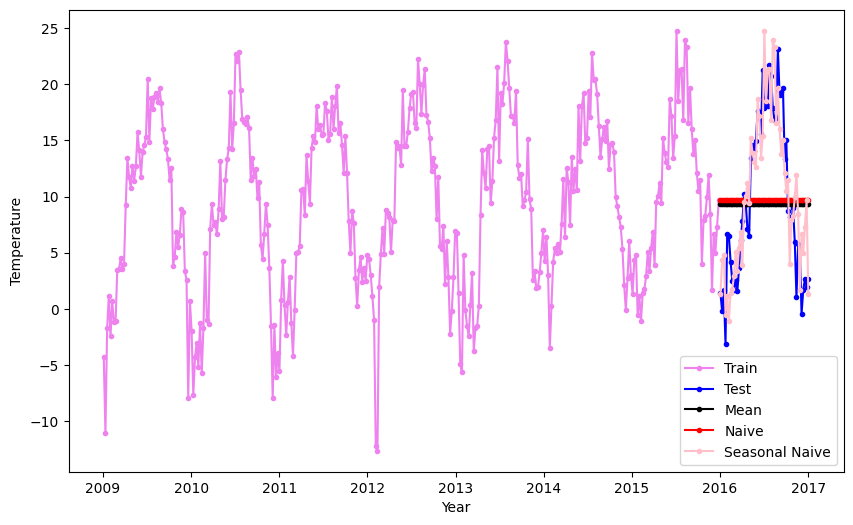

In [936]:
# 1. Mean Method
model = HistoricAverage().fit(train_temp)
forecast_values_Mean_v1 = model.predict(53) # forecasting horizon ('mean')
forecast_values_Mean_v2 = model.predict_in_sample() # in-sample predictions ('fitted')
forecast_values_Mean_v3 = model.forecast(train_temp, h=14, fitted=True) # it returns also in-sample predictions ('mean' and 'fitted')
# display(forecast_values_Mean_v1)
# display(forecast_values_Mean_v2)
# display(forecast_values_Mean_v3)

# 2. Naive Method
model = Naive().fit(train_temp)
forecast_values_Naive_v1 = model.predict(53)
#display(forecast_values_Naive_v1)

# 3. Seasonal Naive Method
model = SeasonalNaive(season_length= 52).fit(train_temp)
forecast_values_SeasNaive_v1 = model.predict(53)
#display(forecast_values_SeasNaive_v1)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train_temp.index, train_temp, color='violet',marker = '.',label='Train')
plt.plot(test_temp.index, test_temp, color='blue',marker = '.',label='Test')
plt.plot(test_temp.index, forecast_values_Mean_v1['mean'], color='black',marker = '.', label='Mean')
plt.plot(test_temp.index, forecast_values_Naive_v1['mean'], color='red',marker = '.', label='Naive')
plt.plot(test_temp.index, forecast_values_SeasNaive_v1['mean'], color='pink',marker = '.', label='Seasonal Naive')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#### Drift Method

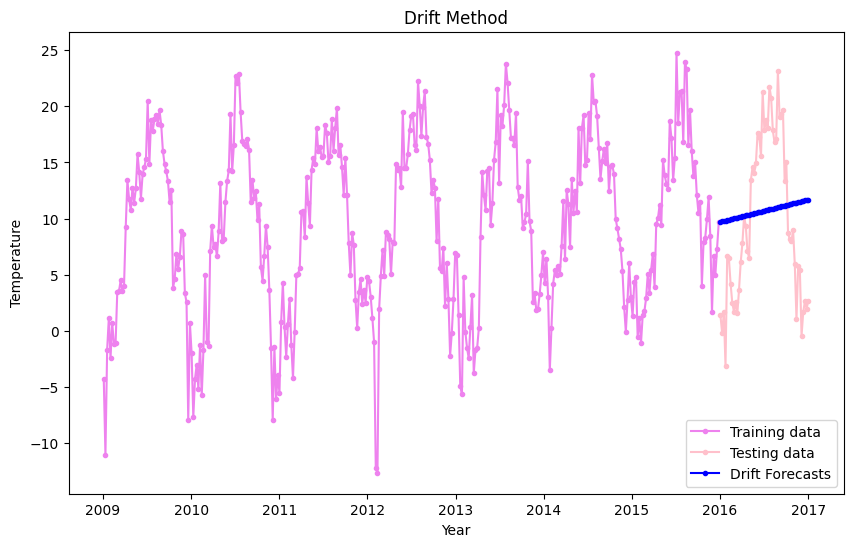

In [937]:
# 4) Drift Method --> variation on Naive, it allows the forecasts to increase or decrease over time (amout of change is called drift)
model = RandomWalkWithDrift() # seasonality has to be specified
model = model.fit(train_temp)
forecast_values = model.predict(len(test_temp))

plt.figure(figsize=(10, 6))
plt.plot(train_temp, color='violet',marker = '.',label='Training data')
plt.plot(test_temp, color='pink', marker = '.',label='Testing data')
plt.plot(test_temp.index, forecast_values['mean'], color='blue', marker = '.', label='Drift Forecasts' )
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Drift Method')
plt.legend()
plt.show()

#### Exponential Smoothing Models

##### Simple Exponential Smoothing

In [950]:
model = ETSModel(train_temp, error = 'add', seasonal_periods = 52).fit()

# Estimated parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)
# display(tab)

# The fitted model contains several attributes and methods that can be used to evaluate the results and derive the in-sample predictions and out-of-sample
# Option 1 - .predict() --> only in-sample prediction and out-of-sample forecasting, depending on the start/end values
df_predict = model.predict(start=test_temp.index[0], end=test_temp.index[-1]) # for out-of-sample only, start = '2016'
# print('Option 1')
# print(df_predict)

# Option 2 - .get_prediction + .summary_frame() --> in-sample prediction and out-of-sample forecasting + prediction interval
predictions = model.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df_getpredict = predictions.summary_frame()
# print('Option 2')
# print(df_getpredict)

# Option 3 - .forecast() --> only out of sample forecasting
df_forecast = model.forecast(52)
# print('Option 3')
# print(df_forecast)

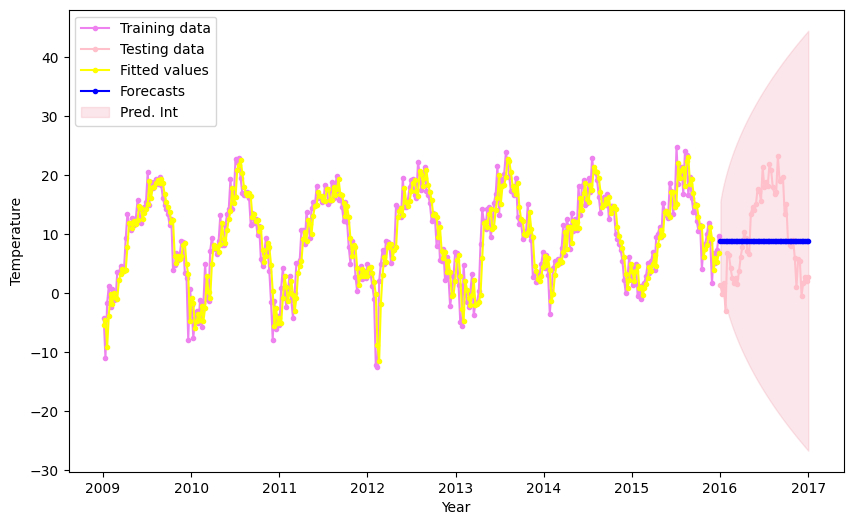

In [951]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train_temp, color='violet',marker = '.',label='Training data')
plt.plot(test_temp, color='pink', marker = '.',label='Testing data')
plt.plot(model.fittedvalues,color='yellow', marker = '.', label='Fitted values')
plt.plot(df_getpredict['mean'], color='blue', marker = '.', label='Forecasts')
plt.fill_between(df_getpredict.index, df_getpredict['pi_lower'], df_getpredict['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

All forecasts with SES take the same value, equal to the last level component. This model is only suitable if the time series has no trend or seasonal component, so I'm not surprised by the "bad" results.

In [952]:
print('AIC:', model.aic)

AIC: 1945.4389494754937


##### Double Exponential Smoothing
This takes into account the trend of the time series data.

In [941]:
# Train the model
model = ETSModel(train_temp, error = 'add', trend='add').fit()

# Forecasting in the future and prediction interval
pred = model.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df = pred.summary_frame()
forecasts = df['mean']

# Model parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)
tab

Param Name    Values
0  smoothing_level  0.716633
1  smoothing_trend  0.000072
2    initial_level -5.465449
3    initial_trend  0.039185

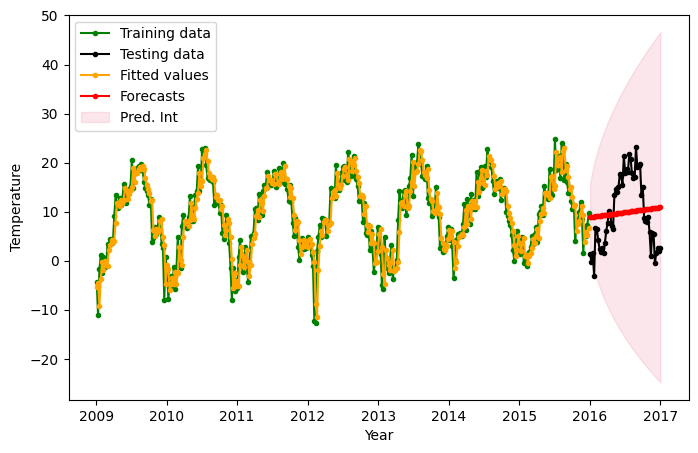

In [942]:
# Visualization
plt.figure(figsize=(8,5))
plt.plot(train_temp, color='green',marker = '.',label='Training data')
plt.plot(test_temp, color='black', marker = '.',label='Testing data')
plt.plot(model.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [943]:
print('AIC:', model.aic)

AIC: 1949.383951122871


##### Damped Exponential Smoothing

In [944]:
# Train the model
model = ETSModel(train_temp, error = 'add', trend='add').fit()

# Forecasting in the future and prediction interval
pred = model.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df = pred.summary_frame()
forecasts = df['mean']

# Model parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)

Model Parameters - Damping


Param Name    Values
0  smoothing_level  0.650649
1  smoothing_trend  0.031725
2    damping_trend  0.875621
3    initial_level -8.385424
4    initial_trend  2.290015

Model Parameters - No Damping


Param Name    Values
0  smoothing_level  0.716633
1  smoothing_trend  0.000072
2    initial_level -5.465449
3    initial_trend  0.039185

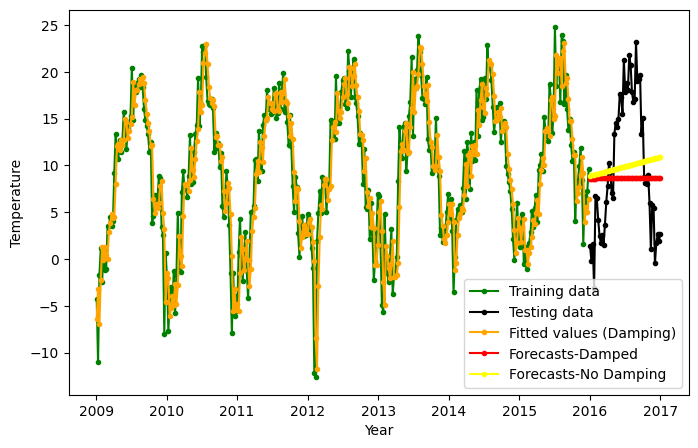

In [945]:
# Model - Damped
model_damped = ETSModel(train_temp, error = 'add', trend='add', damped_trend=True).fit()

# Forecasting in the future and prediction interval
pred = model_damped.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df = pred.summary_frame()
forecasts_damped = df['mean']

# Model parameters with damping
tab = {'Param Name': model_damped.param_names, 'Values': model_damped.params}
tab = pd.DataFrame(tab)
print('Model Parameters - Damping')
display(tab)

# Model without Damping
model_nodamp = ETSModel(train_temp, error = 'add', trend='add').fit()

# Forecasting in the future and prediction interval
pred = model_nodamp.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df = pred.summary_frame()
forecasts_nodamp = df['mean']

# Model parameters without damping
tab = {'Param Name': model_nodamp.param_names, 'Values': model_nodamp.params}
tab = pd.DataFrame(tab)
print('Model Parameters - No Damping')
display(tab)

# Visualization
plt.figure(figsize=(8,5))
plt.plot(train_temp, color='green',marker = '.', label='Training data')
plt.plot(test_temp, color='black', marker = '.',label='Testing data')
plt.plot(model_damped.fittedvalues,color='orange',marker = '.', label='Fitted values (Damping)')
plt.plot(forecasts_damped, color='red', marker = '.',label='Forecasts-Damped')
plt.plot(forecasts_nodamp, color='yellow', marker = '.',label='Forecasts-No Damping')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [946]:
print('AIC:', model.aic)

AIC: 1949.383951122871


##### Triple Exponential Smoothing
This takes into account the trend and the seasonality of the time series data.

In [947]:
# Model
model = ETSModel(train_temp, error = 'add', trend='add', seasonal='add',seasonal_periods=52, damped_trend=True).fit()
# seasonal_periods --> The number of periods in a complete seasonal cycle for seasonal (Holt-Winters) models.
# For example, 4 for quarterly data with an annual cycle or 7 for daily data with a weekly cycle.

# Forecasting in the future and prediction interval
pred = model.get_prediction(start=test_temp.index[0], end=test_temp.index[-1])
df = pred.summary_frame()
forecasts = df['mean']

# Model parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)
tab

Param Name     Values
0       smoothing_level   0.214390
1       smoothing_trend   0.000021
2    smoothing_seasonal   0.000079
3         damping_trend   0.800000
4         initial_level  -8.550083
5         initial_trend   3.570539
6    initial_seasonal.0  -0.681705
7    initial_seasonal.1  -3.530830
8    initial_seasonal.2  -2.175061
9    initial_seasonal.3  -2.364964
10   initial_seasonal.4   1.239894
11   initial_seasonal.5   1.672628
12   initial_seasonal.6   3.747191
13   initial_seasonal.7   4.309189
14   initial_seasonal.8   5.140103
15   initial_seasonal.9   4.208930
16  initial_seasonal.10   5.190283
17  initial_seasonal.11   8.308899
18  initial_seasonal.12   8.856106
19  initial_seasonal.13   9.833850
20  initial_seasonal.14  10.387695
21  initial_seasonal.15  12.655987
22  initial_seasonal.16  12.459310
23  initial_seasonal.17  14.045396
24  initial_seasonal.18  15.291852
25  initial_seasonal.19  15.236085
26  initial_seasonal.20  15.671351
27  initial_seasonal.21  16.381715
28  initial_seasonal.22  15.479252
29  initial_seasonal.23  15.061464
30  initial_seasonal.24  16.242397
31  initial_seasonal.25  13.919344
32  initial_seasonal.26  12.963401
33  initial_seasonal.27  12.845706
34  initial_seasonal.28  13.094897
35  initial_seasonal.29  10.242131
36  initial_seasonal.30  11.200166
37  initial_seasonal.31  10.056666
38  initial_seasonal.32   9.669281
39  initial_seasonal.33   7.150925
40  initial_seasonal.34   9.317835
41  initial_seasonal.35   7.002639
42  initial_seasonal.36   5.748905
43  initial_seasonal.37   4.305537
44  initial_seasonal.38   3.430079
45  initial_seasonal.39   2.831068
46  initial_seasonal.40   1.274027
47  initial_seasonal.41   0.536009
48  initial_seasonal.42  -0.499680
49  initial_seasonal.43  -1.191725
50  initial_seasonal.44  -2.578336
51  initial_seasonal.45  -4.885193
52  initial_seasonal.46  -3.687930
53  initial_seasonal.47  -5.644854
54  initial_seasonal.48  -2.157813
55  initial_seasonal.49  -0.395703
56  initial_seasonal.50  -2.228831
57  initial_seasonal.51   0.000000

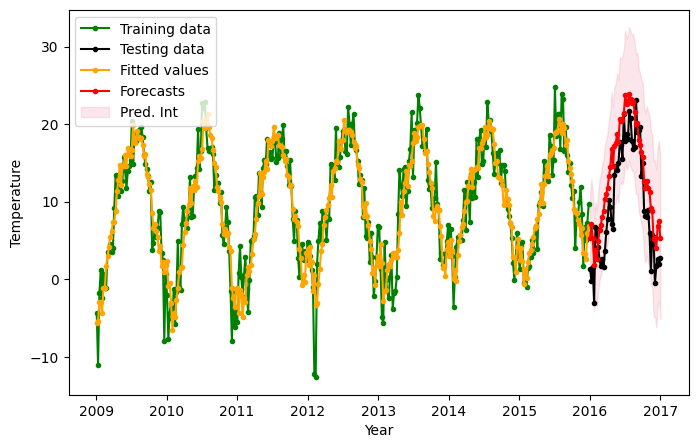

In [948]:
# Visualization
plt.figure(figsize=(8,5))
plt.plot(train_temp, color='green',marker = '.',label='Training data')
plt.plot(test_temp, color='black', marker = '.',label='Testing data')
plt.plot(model.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [949]:
print('AIC:', model.aic)

AIC: 1924.838848488752
